In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist, fashion_mnist

batch_size = 1024
original_dim = 784
latent_dim = 2
intermediate_dim = 512
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h_ = Dense(intermediate_dim, activation='relu')(x)
h = Dense(intermediate_dim // 2, activation='relu')(h_)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim // 2, activation='relu')
decoder_h_ = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
h__decoded = decoder_h_(h_decoded)
x_decoded_mean = decoder_mean(h__decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss

def custom_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

# vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop', loss=custom_loss)
vae.summary()


# train the VAE on MNIST digits
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

/home/marcelra/Pycharmprojects/music-generator/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [2]:
def fit_and_plot(n_epochs=1):
    vae.fit(x_train, y=x_train,
        shuffle=True,
        epochs=n_epochs,
        batch_size=batch_size)

    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)

    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()

    # build a digit generator that can sample from the learned distribution
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _h__decoded = decoder_h_(_h_decoded)
    _x_decoded_mean = decoder_mean(_h__decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    # display a 2D manifold of the digits
    n = 16  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(20, 20))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()    

In [3]:
vae.fit(x_train, y=x_train,
        shuffle=True,
        epochs=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 6s 104us/step - loss: 368.1109 - val_loss: 327.4666


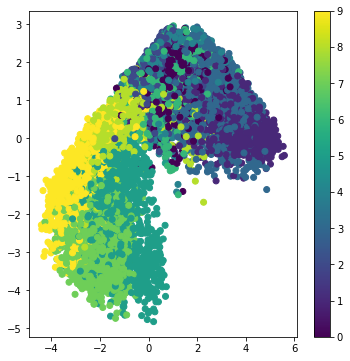

In [4]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_h__decoded = decoder_h_(_h_decoded)
_x_decoded_mean = decoder_mean(_h__decoded)
generator = Model(decoder_input, _x_decoded_mean)

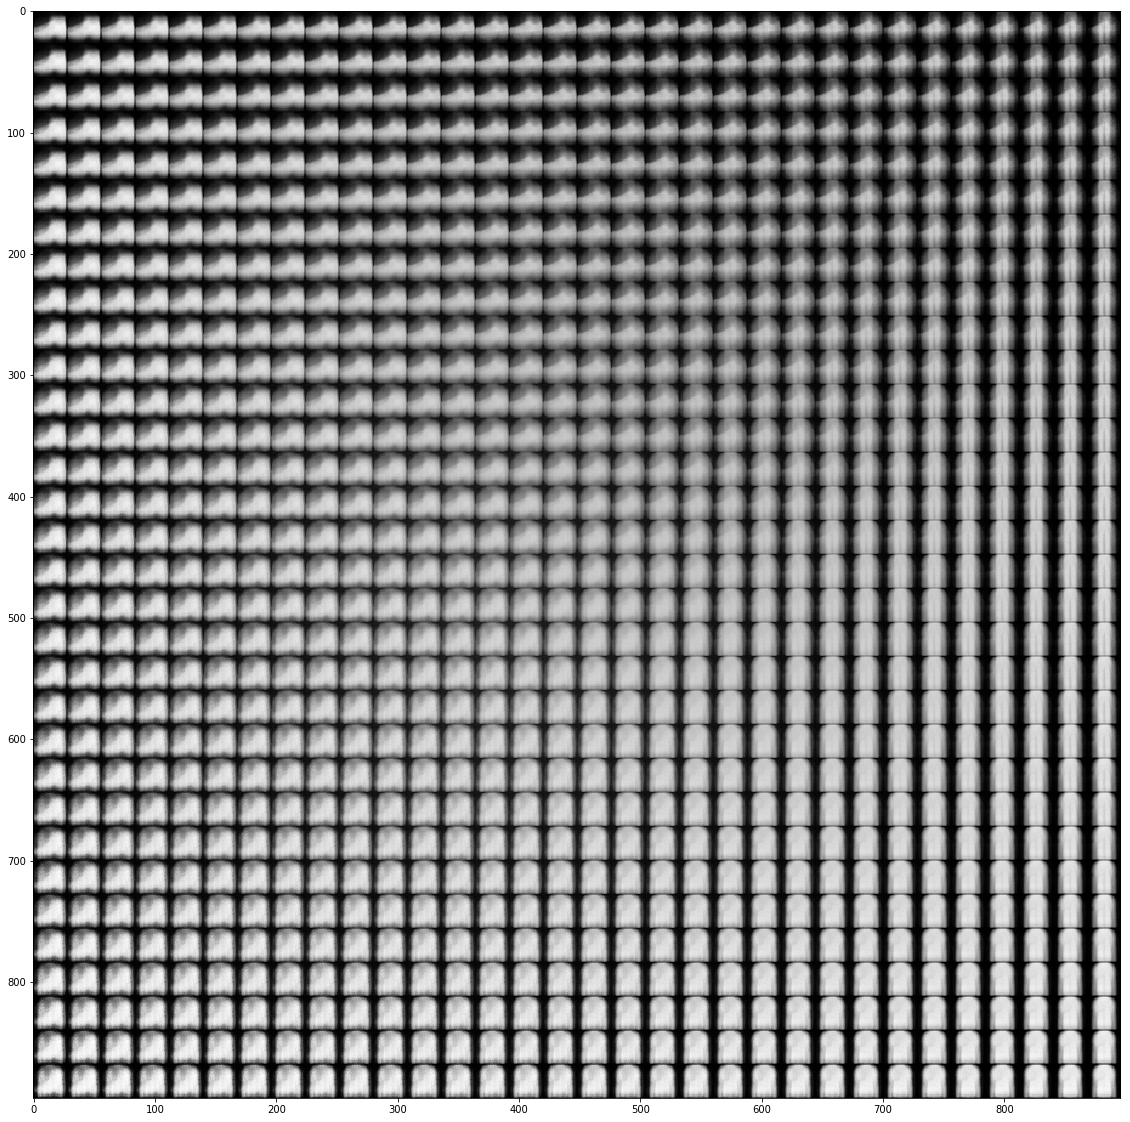

In [5]:
# display a 2D manifold of the digits
n = 32  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Epoch 1/300
60000/60000 [==============================] - 6s 97us/step - loss: 278.4191
Epoch 2/300
60000/60000 [==============================] - 6s 97us/step - loss: 276.5176
Epoch 3/300
60000/60000 [==============================] - 6s 97us/step - loss: 275.0617
Epoch 4/300
60000/60000 [==============================] - 6s 98us/step - loss: 273.8058
Epoch 5/300
60000/60000 [==============================] - 6s 97us/step - loss: 272.9095
Epoch 6/300
60000/60000 [==============================] - 6s 97us/step - loss: 271.6385
Epoch 7/300
60000/60000 [==============================] - 6s 99us/step - loss: 270.7888
Epoch 8/300
60000/60000 [==============================] - 6s 98us/step - loss: 269.9173
Epoch 9/300
60000/60000 [==============================] - 6s 99us/step - loss: 269.2623
Epoch 10/300
60000/60000 [==============================] - 6s 99us/step - loss: 268.7136
Epoch 11/300
60000/60000 [==============================] - 6s 98us/step - loss: 267.9718
Epoch 12/300
60000/

60000/60000 [==============================] - 6s 96us/step - loss: 255.8183
Epoch 92/300
60000/60000 [==============================] - 6s 96us/step - loss: 255.5679
Epoch 93/300
60000/60000 [==============================] - 6s 97us/step - loss: 255.8221
Epoch 94/300
60000/60000 [==============================] - 6s 96us/step - loss: 255.6186
Epoch 95/300
60000/60000 [==============================] - 6s 100us/step - loss: 255.3401
Epoch 96/300
60000/60000 [==============================] - 6s 100us/step - loss: 255.4325
Epoch 97/300
60000/60000 [==============================] - 6s 99us/step - loss: 255.3602
Epoch 98/300
60000/60000 [==============================] - 6s 101us/step - loss: 255.4192
Epoch 99/300
60000/60000 [==============================] - 6s 96us/step - loss: 255.1319
Epoch 100/300
60000/60000 [==============================] - 5s 89us/step - loss: 255.2689
Epoch 101/300
60000/60000 [==============================] - 5s 88us/step - loss: 255.3385
Epoch 102/300
6000

60000/60000 [==============================] - 5s 90us/step - loss: 252.3115
Epoch 182/300
60000/60000 [==============================] - 5s 89us/step - loss: 252.3988
Epoch 183/300
60000/60000 [==============================] - 5s 88us/step - loss: 252.3171
Epoch 184/300
60000/60000 [==============================] - 5s 89us/step - loss: 252.4275
Epoch 185/300
60000/60000 [==============================] - 5s 89us/step - loss: 252.4679
Epoch 186/300
60000/60000 [==============================] - 5s 89us/step - loss: 252.2944
Epoch 187/300
60000/60000 [==============================] - 5s 89us/step - loss: 252.2227
Epoch 188/300
60000/60000 [==============================] - 5s 89us/step - loss: 252.3439
Epoch 189/300
60000/60000 [==============================] - 5s 89us/step - loss: 252.4344
Epoch 190/300
60000/60000 [==============================] - 5s 88us/step - loss: 252.2833
Epoch 191/300
60000/60000 [==============================] - 5s 89us/step - loss: 252.2384
Epoch 192/300

60000/60000 [==============================] - 5s 90us/step - loss: 250.8736
Epoch 272/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.9034
Epoch 273/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.9292
Epoch 274/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.9357
Epoch 275/300
60000/60000 [==============================] - 5s 89us/step - loss: 251.1065
Epoch 276/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.7468
Epoch 277/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.9644
Epoch 278/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.9988
Epoch 279/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.7100
Epoch 280/300
60000/60000 [==============================] - 5s 88us/step - loss: 250.7682
Epoch 281/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.8981
Epoch 282/300

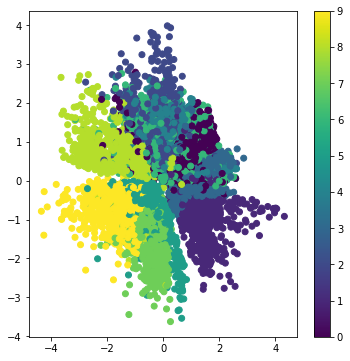

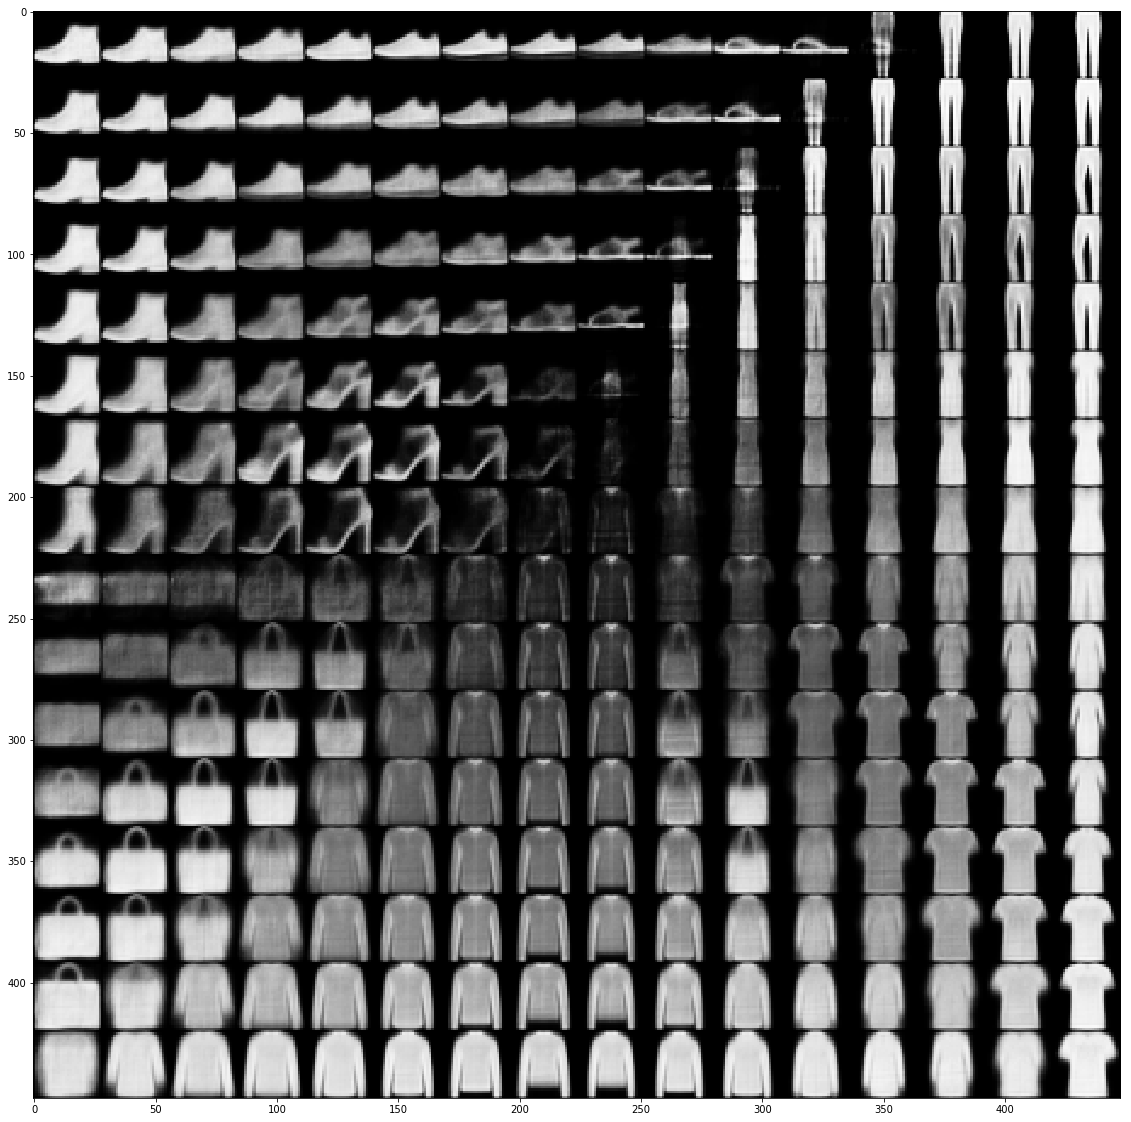

Epoch 1/300
60000/60000 [==============================] - 5s 90us/step - loss: 250.6175
Epoch 2/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.5188
Epoch 3/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.4976
Epoch 4/300
60000/60000 [==============================] - 5s 88us/step - loss: 250.4716
Epoch 5/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.4740
Epoch 6/300
60000/60000 [==============================] - 5s 88us/step - loss: 250.7558
Epoch 7/300
60000/60000 [==============================] - 5s 88us/step - loss: 250.9714
Epoch 8/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.3976
Epoch 9/300
60000/60000 [==============================] - 5s 90us/step - loss: 250.4226
Epoch 10/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.3964
Epoch 11/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.6792
Epoch 12/300
60000/

60000/60000 [==============================] - 5s 89us/step - loss: 249.7485
Epoch 93/300
60000/60000 [==============================] - 5s 89us/step - loss: 249.7582
Epoch 94/300
60000/60000 [==============================] - 5s 89us/step - loss: 249.7320
Epoch 95/300
60000/60000 [==============================] - 5s 89us/step - loss: 249.7128
Epoch 96/300
60000/60000 [==============================] - 5s 90us/step - loss: 250.0233
Epoch 97/300
60000/60000 [==============================] - 5s 90us/step - loss: 250.2291
Epoch 98/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.1693
Epoch 99/300
60000/60000 [==============================] - 5s 89us/step - loss: 250.5130
Epoch 100/300
60000/60000 [==============================] - 5s 89us/step - loss: 249.8809
Epoch 101/300
60000/60000 [==============================] - 5s 90us/step - loss: 250.3925
Epoch 102/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.9982
Epoch 103/300
60000/

60000/60000 [==============================] - 5s 90us/step - loss: 249.5370
Epoch 183/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.3910
Epoch 184/300
60000/60000 [==============================] - 5s 89us/step - loss: 249.4218
Epoch 185/300
60000/60000 [==============================] - 5s 89us/step - loss: 249.4037
Epoch 186/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.4901
Epoch 187/300
60000/60000 [==============================] - 5s 89us/step - loss: 249.4065
Epoch 188/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.4483
Epoch 189/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.2259
Epoch 190/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.3009
Epoch 191/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.1555
Epoch 192/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.1461
Epoch 193/300

60000/60000 [==============================] - 5s 90us/step - loss: 249.2910
Epoch 273/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.1220
Epoch 274/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.7281
Epoch 275/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.7451
Epoch 276/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.7903
Epoch 277/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.8652
Epoch 278/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.0421
Epoch 279/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.0600
Epoch 280/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.1611
Epoch 281/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.5902
Epoch 282/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.1546
Epoch 283/300

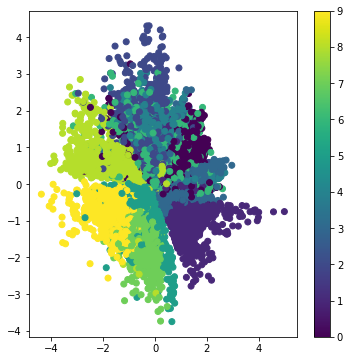

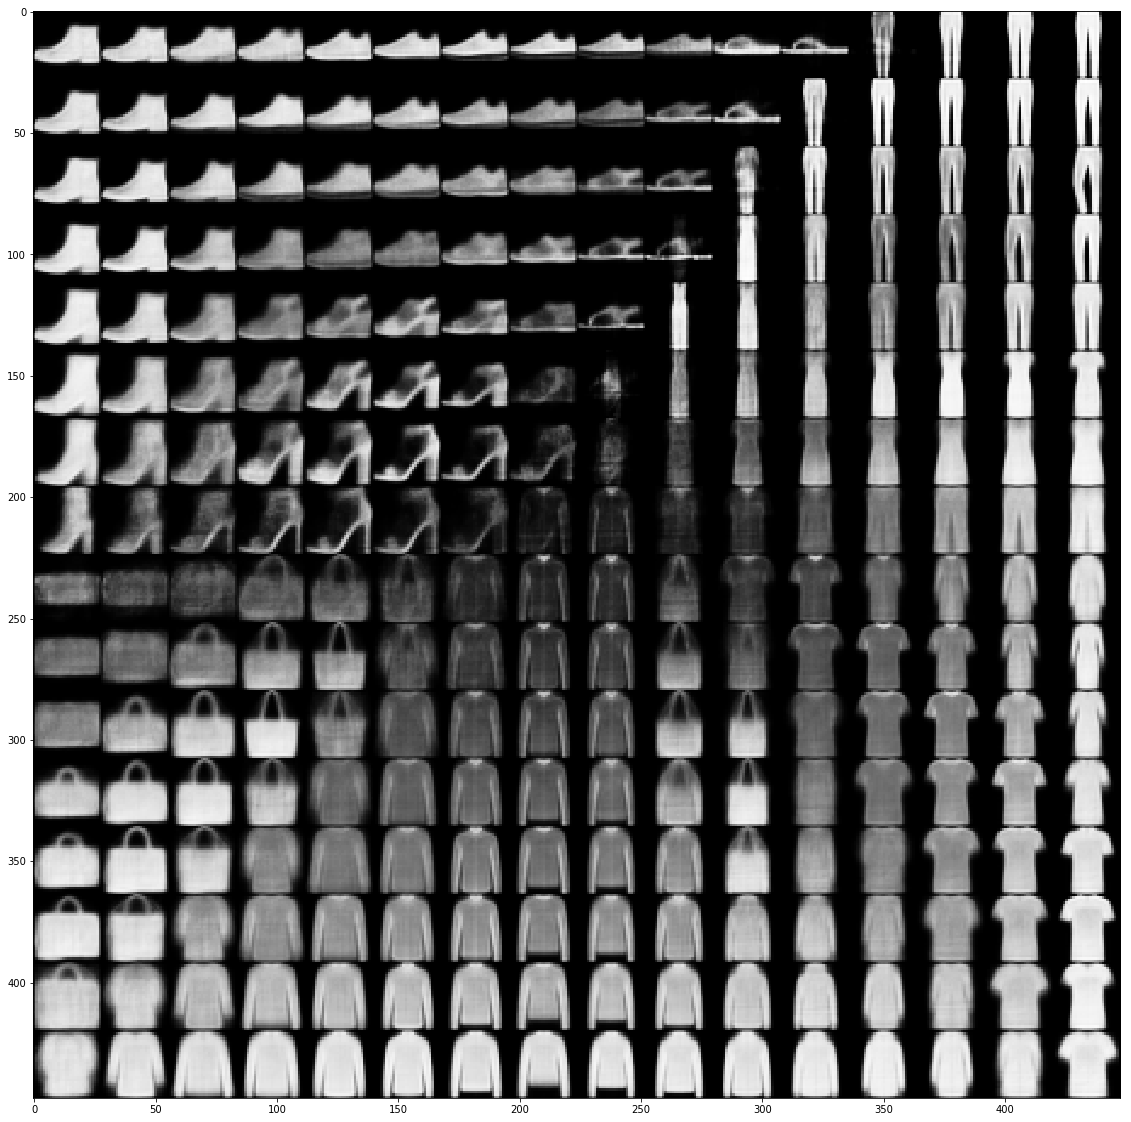

Epoch 1/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.5947
Epoch 2/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.6256
Epoch 3/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.6070
Epoch 4/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.7662
Epoch 5/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.7903
Epoch 6/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.6151
Epoch 7/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.8917
Epoch 8/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.9890
Epoch 9/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.7532
Epoch 10/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.7217
Epoch 11/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.7268
Epoch 12/300
60000/

60000/60000 [==============================] - 6s 92us/step - loss: 248.8320
Epoch 93/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.8251
Epoch 94/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.4289
Epoch 95/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.8744
Epoch 96/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.0884
Epoch 97/300
60000/60000 [==============================] - 5s 91us/step - loss: 250.1861
Epoch 98/300
60000/60000 [==============================] - 5s 90us/step - loss: 250.5111
Epoch 99/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.9882
Epoch 100/300
60000/60000 [==============================] - 5s 91us/step - loss: 250.1237
Epoch 101/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.2517
Epoch 102/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.2432
Epoch 103/300
60000/

60000/60000 [==============================] - 5s 89us/step - loss: 248.3980
Epoch 183/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.4821
Epoch 184/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.8521
Epoch 185/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.7198
Epoch 186/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.4872
Epoch 187/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0912
Epoch 188/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1890
Epoch 189/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.2639
Epoch 190/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1522
Epoch 191/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.4198
Epoch 192/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.4452
Epoch 193/300

60000/60000 [==============================] - 5s 89us/step - loss: 249.3754
Epoch 273/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.3827
Epoch 274/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.5184
Epoch 275/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.3280
Epoch 276/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1743
Epoch 277/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.3162
Epoch 278/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0894
Epoch 279/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0908
Epoch 280/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.9284
Epoch 281/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0539
Epoch 282/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.3258
Epoch 283/300

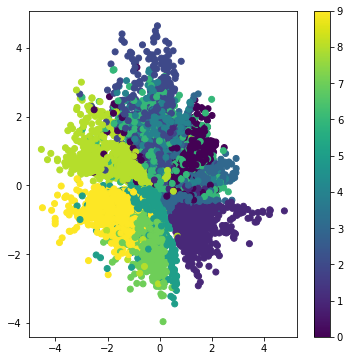

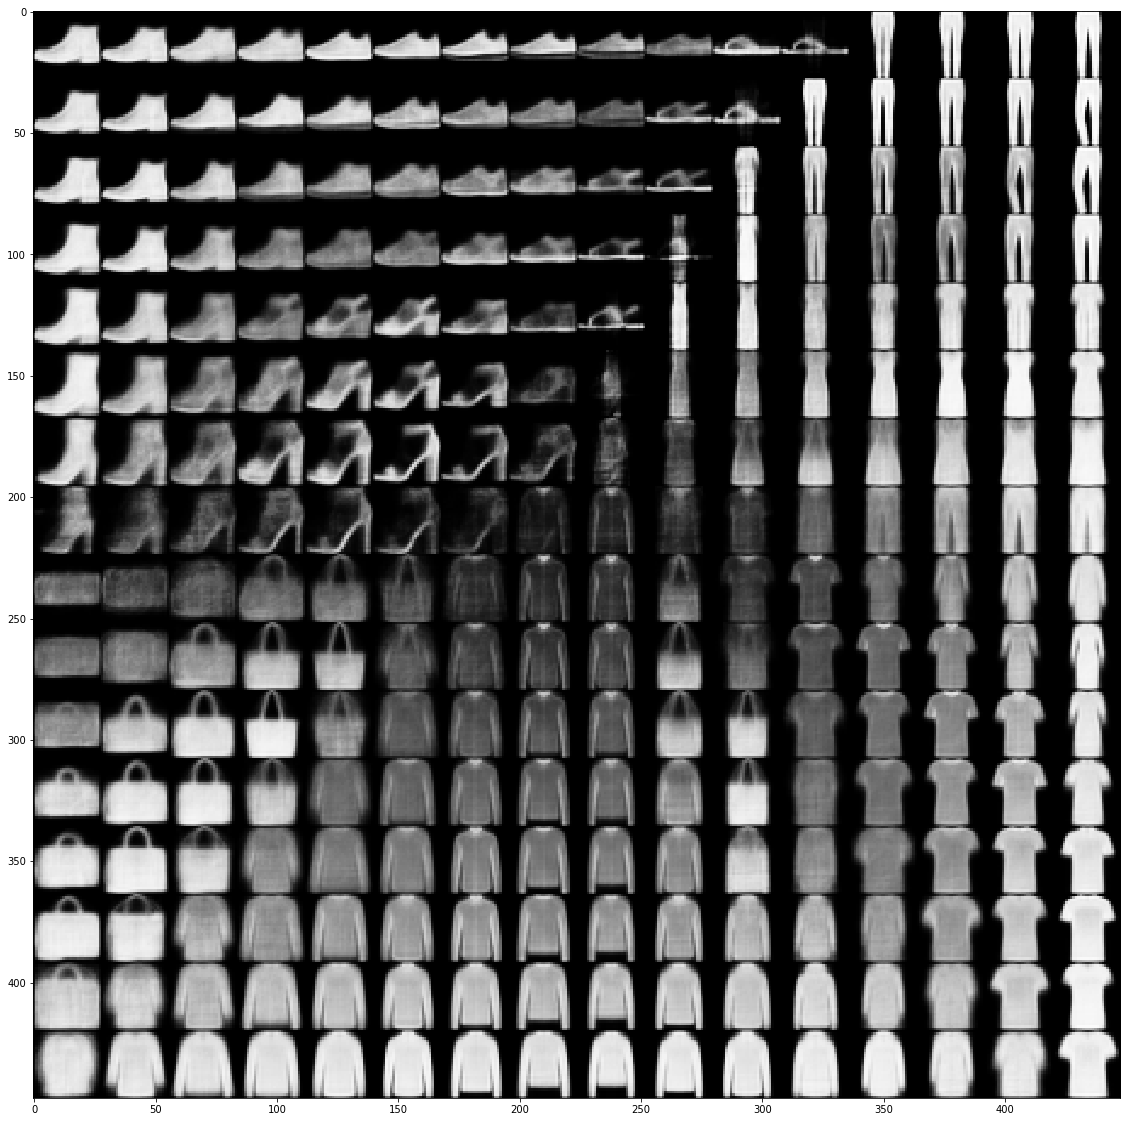

Epoch 1/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.9246
Epoch 2/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.9416
Epoch 3/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.9823
Epoch 4/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8970
Epoch 5/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.8430
Epoch 6/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.9451
Epoch 7/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0147
Epoch 8/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8707
Epoch 9/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0966
Epoch 10/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.3828
Epoch 11/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.2102
Epoch 12/300
60000/

60000/60000 [==============================] - 5s 89us/step - loss: 247.8529
Epoch 93/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.4711
Epoch 94/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.8241
Epoch 95/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.9029
Epoch 96/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.9260
Epoch 97/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.3478
Epoch 98/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.2900
Epoch 99/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.6709
Epoch 100/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.6332
Epoch 101/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.3607
Epoch 102/300
60000/60000 [==============================] - 5s 88us/step - loss: 247.9421
Epoch 103/300
60000/

60000/60000 [==============================] - 5s 90us/step - loss: 247.9954
Epoch 183/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.6844
Epoch 184/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8374
Epoch 185/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0174
Epoch 186/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.7175
Epoch 187/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8153
Epoch 188/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1603
Epoch 189/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.4341
Epoch 190/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.7808
Epoch 191/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.6427
Epoch 192/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.6713
Epoch 193/300

60000/60000 [==============================] - 5s 88us/step - loss: 248.6803
Epoch 273/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.7052
Epoch 274/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.4158
Epoch 275/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.5304
Epoch 276/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.6453
Epoch 277/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.6120
Epoch 278/300
60000/60000 [==============================] - 5s 88us/step - loss: 248.5175
Epoch 279/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.6328
Epoch 280/300
60000/60000 [==============================] - 5s 89us/step - loss: 249.0586
Epoch 281/300
60000/60000 [==============================] - 5s 89us/step - loss: 249.3976
Epoch 282/300
60000/60000 [==============================] - 5s 89us/step - loss: 249.8932
Epoch 283/300

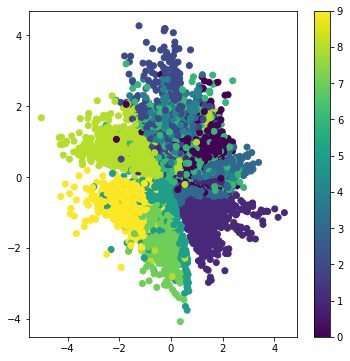

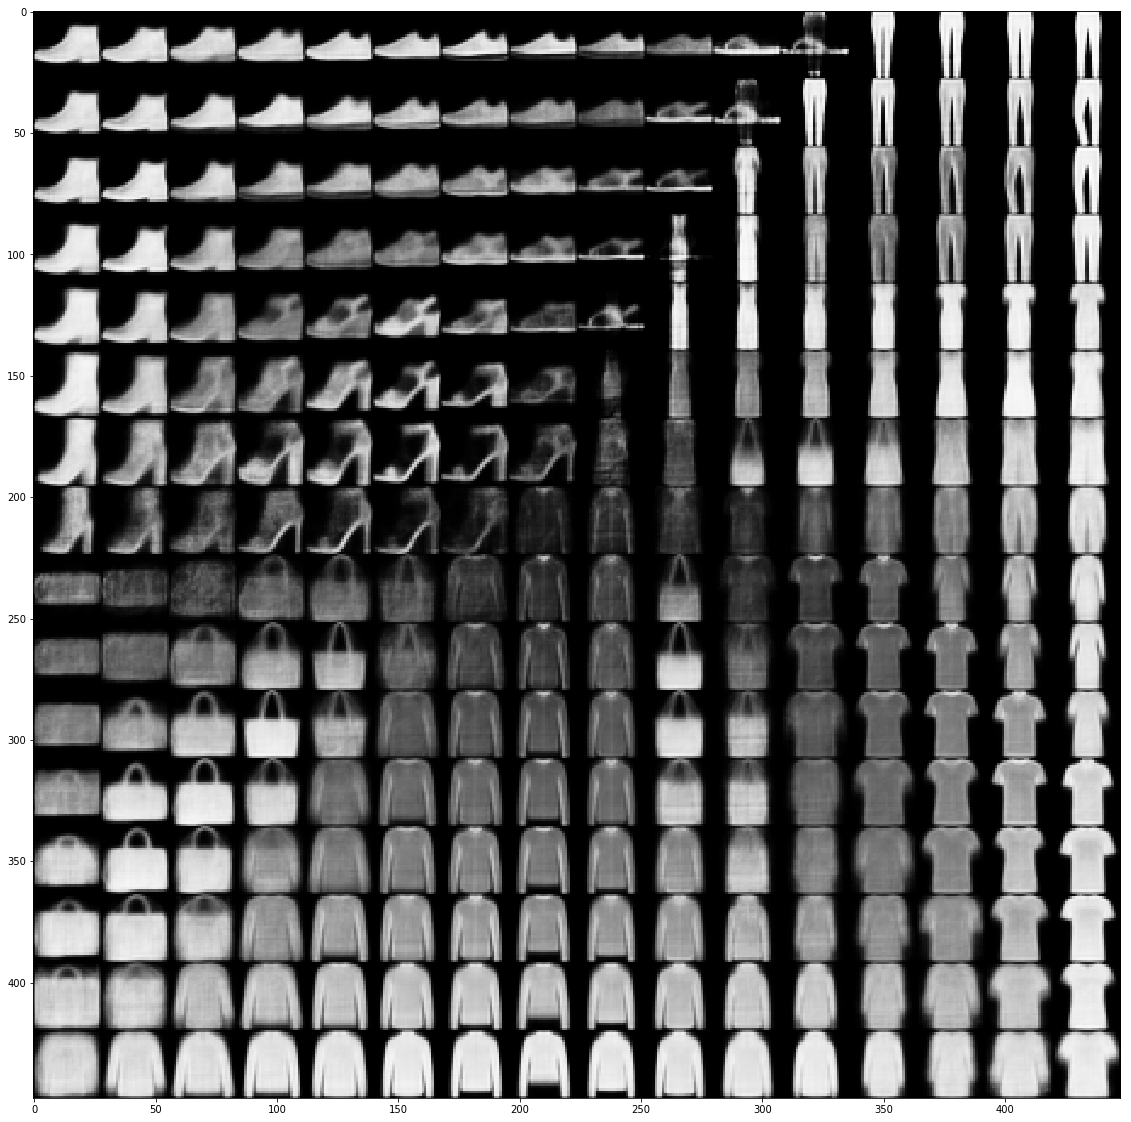

Epoch 1/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.3758
Epoch 2/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.9241
Epoch 3/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8926
Epoch 4/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8412
Epoch 5/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8268
Epoch 6/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.6536
Epoch 7/300
60000/60000 [==============================] - 5s 88us/step - loss: 247.7133
Epoch 8/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.7220
Epoch 9/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.6743
Epoch 10/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.6611
Epoch 11/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.6715
Epoch 12/300
60000/

60000/60000 [==============================] - 5s 90us/step - loss: 247.9969
Epoch 93/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.2324
Epoch 94/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.0011
Epoch 95/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8804
Epoch 96/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.9648
Epoch 97/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.1819
Epoch 98/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.1920
Epoch 99/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.0696
Epoch 100/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.2474
Epoch 101/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.4409
Epoch 102/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.3598
Epoch 103/300
60000/

60000/60000 [==============================] - 5s 91us/step - loss: 247.7971
Epoch 183/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.0215
Epoch 184/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.3736
Epoch 185/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.2897
Epoch 186/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.4147
Epoch 187/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.2839
Epoch 188/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.9994
Epoch 189/300
60000/60000 [==============================] - 5s 92us/step - loss: 249.4487
Epoch 190/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.3147
Epoch 191/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.9169
Epoch 192/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.3164
Epoch 193/300

60000/60000 [==============================] - 5s 89us/step - loss: 247.9738
Epoch 273/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.2451
Epoch 274/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.9230
Epoch 275/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.9632
Epoch 276/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.2312
Epoch 277/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.3318
Epoch 278/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.1972
Epoch 279/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1569
Epoch 280/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.0239
Epoch 281/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.8641
Epoch 282/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.6818
Epoch 283/300

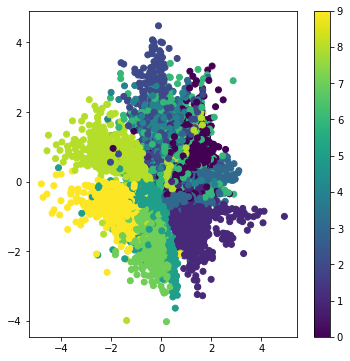

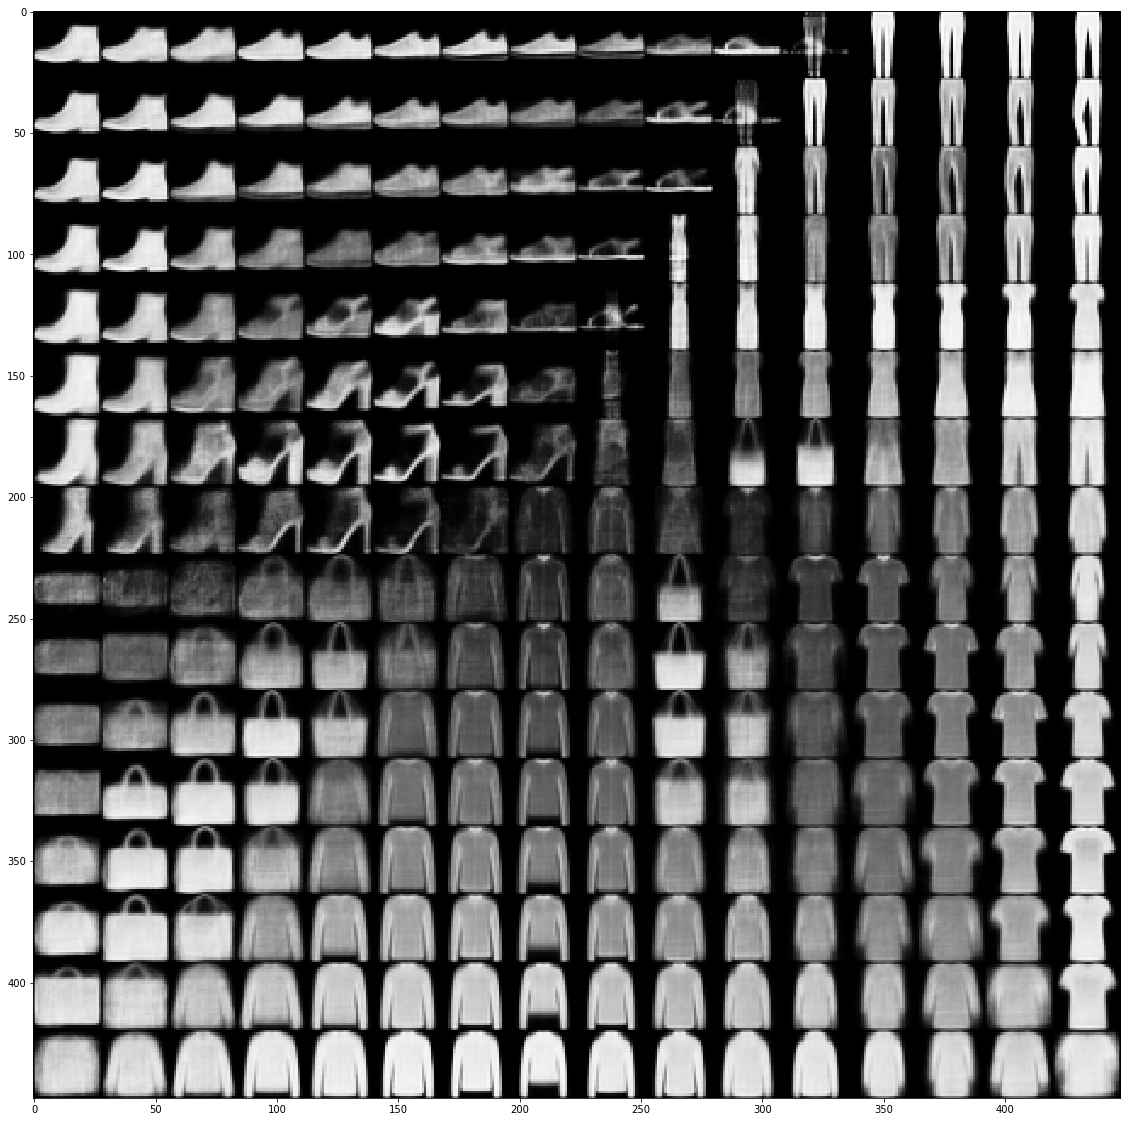

Epoch 1/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.4187
Epoch 2/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1702
Epoch 3/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1492
Epoch 4/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1299
Epoch 5/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.2802
Epoch 6/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.7479
Epoch 7/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0030
Epoch 8/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8439
Epoch 9/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8086
Epoch 10/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.6805
Epoch 11/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.7568
Epoch 12/300
60000/

60000/60000 [==============================] - 5s 91us/step - loss: 248.0026
Epoch 93/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.1047
Epoch 94/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.0010
Epoch 95/300
60000/60000 [==============================] - 5s 91us/step - loss: 247.6829
Epoch 96/300
60000/60000 [==============================] - 6s 93us/step - loss: 247.8936
Epoch 97/300
60000/60000 [==============================] - 5s 91us/step - loss: 247.9205
Epoch 98/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.1732
Epoch 99/300
60000/60000 [==============================] - 5s 91us/step - loss: 247.9890
Epoch 100/300
60000/60000 [==============================] - 6s 92us/step - loss: 247.8289
Epoch 101/300
60000/60000 [==============================] - 5s 91us/step - loss: 247.7574
Epoch 102/300
60000/60000 [==============================] - 5s 91us/step - loss: 247.9474
Epoch 103/300
60000/

60000/60000 [==============================] - 5s 90us/step - loss: 248.0329
Epoch 183/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.3700
Epoch 184/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1806
Epoch 185/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.3594
Epoch 186/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.1152
Epoch 187/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1315
Epoch 188/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.1765
Epoch 189/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.5713
Epoch 190/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.3632
Epoch 191/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.4058
Epoch 192/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.2201
Epoch 193/300

60000/60000 [==============================] - 5s 89us/step - loss: 248.2279
Epoch 273/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1848
Epoch 274/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.0433
Epoch 275/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8292
Epoch 276/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.9198
Epoch 277/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.6902
Epoch 278/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.6313
Epoch 279/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.9958
Epoch 280/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.6435
Epoch 281/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.6243
Epoch 282/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.7158
Epoch 283/300

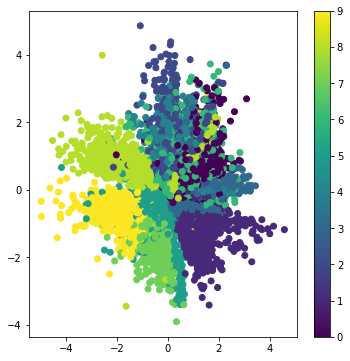

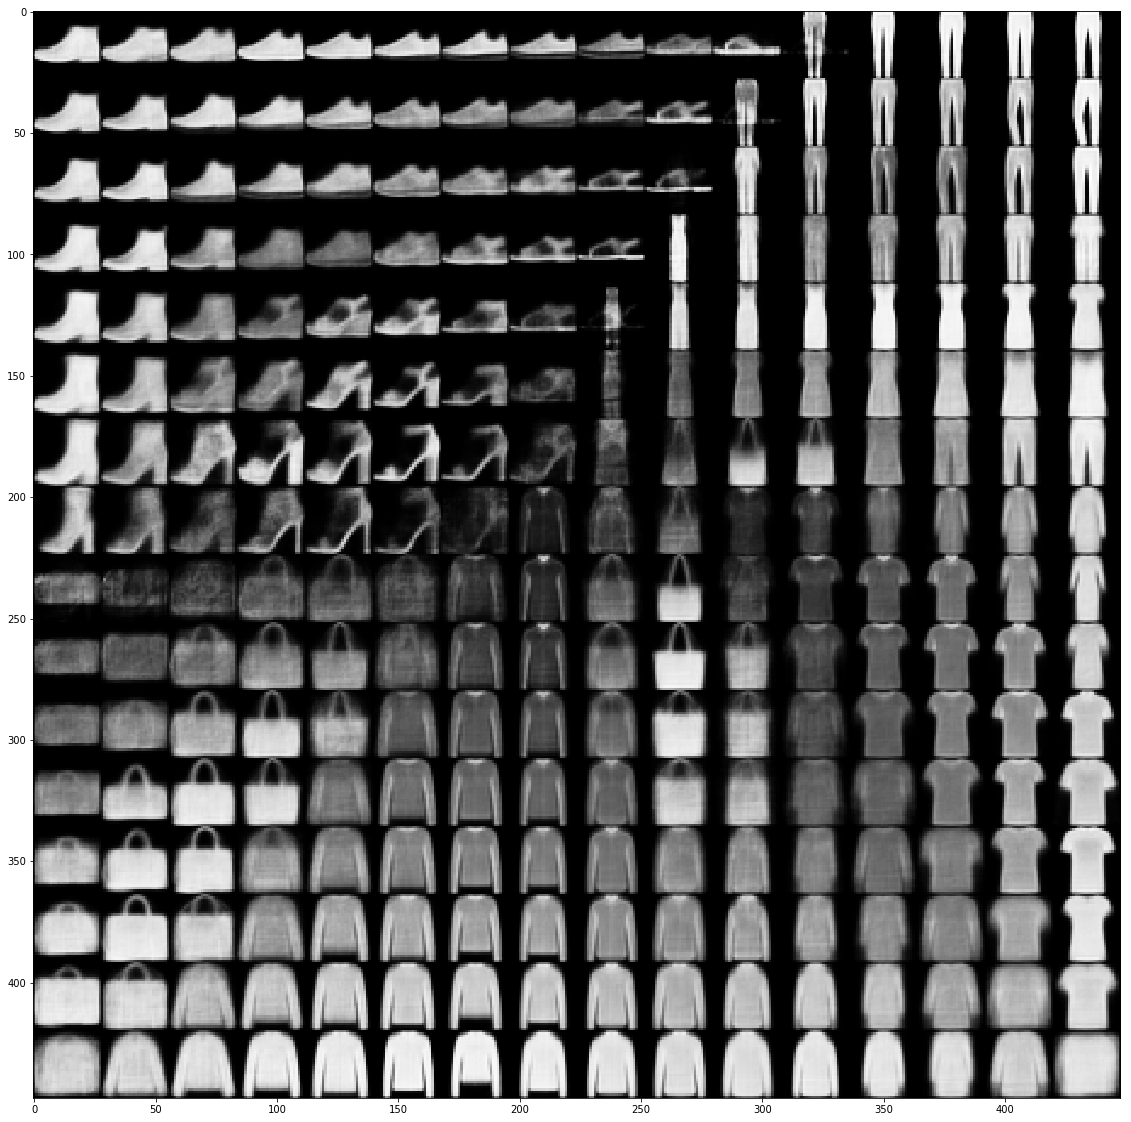

Epoch 1/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.1768
Epoch 2/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.2830
Epoch 3/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.4824
Epoch 4/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.3386
Epoch 5/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.9720
Epoch 6/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.8806
Epoch 7/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.7504
Epoch 8/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.7615
Epoch 9/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.7504
Epoch 10/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.2345
Epoch 11/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.8178
Epoch 12/300
60000/

60000/60000 [==============================] - 5s 89us/step - loss: 247.7964
Epoch 93/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0382
Epoch 94/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.9169
Epoch 95/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.2348
Epoch 96/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.4298
Epoch 97/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.5420
Epoch 98/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.6850
Epoch 99/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.1266
Epoch 100/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0220
Epoch 101/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.0329
Epoch 102/300
60000/60000 [==============================] - 5s 89us/step - loss: 247.9214
Epoch 103/300
60000/

60000/60000 [==============================] - 5s 90us/step - loss: 248.0484
Epoch 183/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.9778
Epoch 184/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.1758
Epoch 185/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.3059
Epoch 186/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.1985
Epoch 187/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.2617
Epoch 188/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.2897
Epoch 189/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.3053
Epoch 190/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.2507
Epoch 191/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.2010
Epoch 192/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.2903
Epoch 193/300

60000/60000 [==============================] - 5s 91us/step - loss: 248.0914
Epoch 273/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.0188
Epoch 274/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.3308
Epoch 275/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.2792
Epoch 276/300
60000/60000 [==============================] - 6s 92us/step - loss: 248.2253
Epoch 277/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.2838
Epoch 278/300
60000/60000 [==============================] - 5s 92us/step - loss: 248.5113
Epoch 279/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.6922
Epoch 280/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.3607
Epoch 281/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.7052
Epoch 282/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.2887
Epoch 283/300

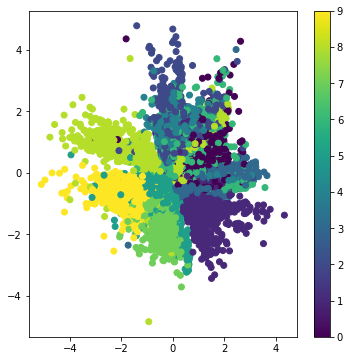

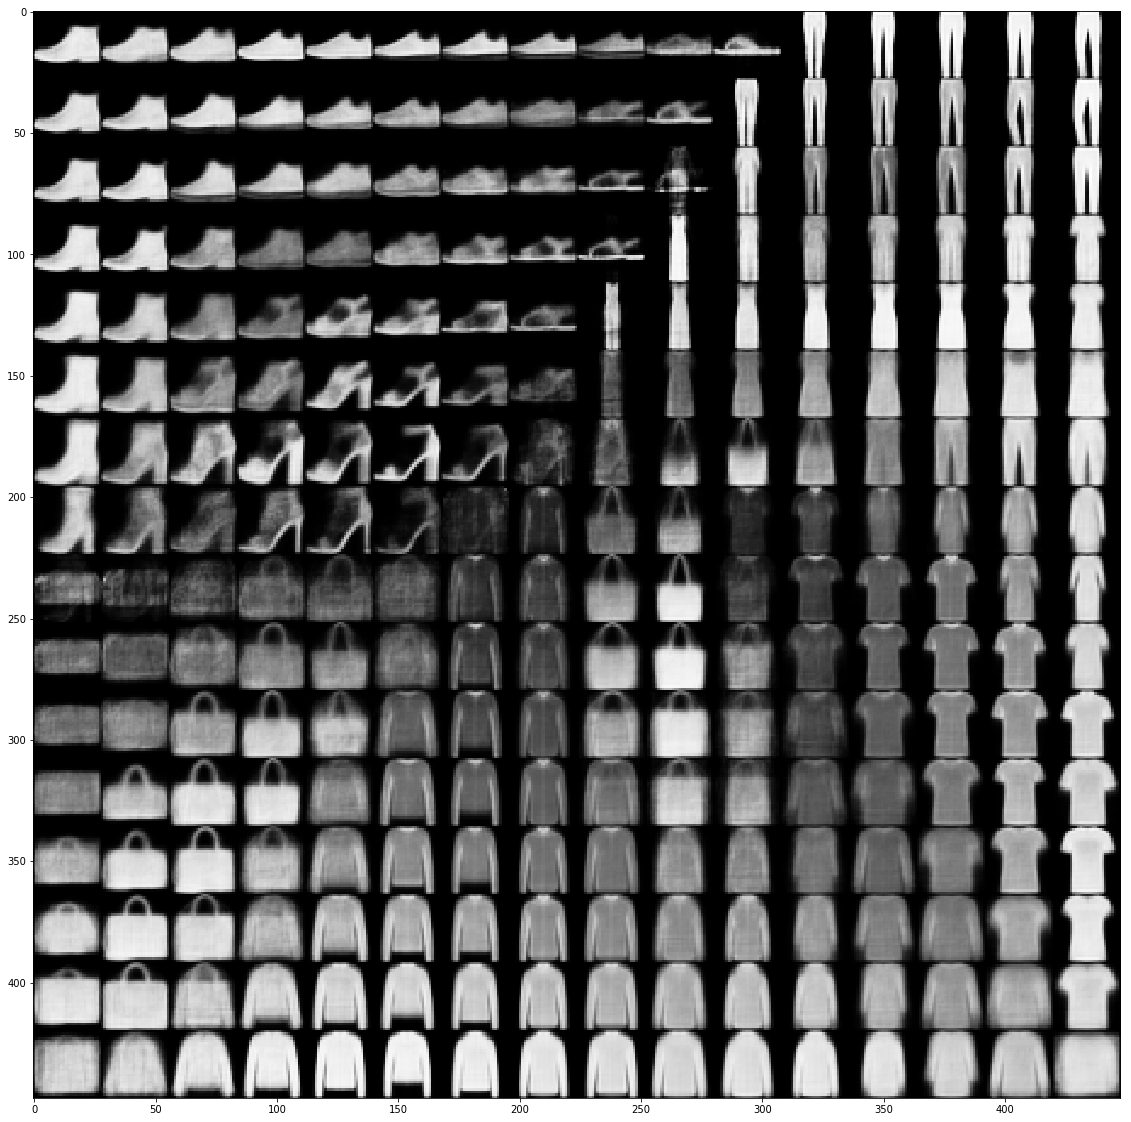

Epoch 1/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.9045
Epoch 2/300
60000/60000 [==============================] - 5s 90us/step - loss: 247.8528
Epoch 3/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.0543
Epoch 4/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.5900
Epoch 5/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.1855
Epoch 6/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.6748
Epoch 7/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.3689
Epoch 8/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.4185
Epoch 9/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.7280
Epoch 10/300
60000/60000 [==============================] - 6s 92us/step - loss: 248.4280
Epoch 11/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.1104
Epoch 12/300
60000/

60000/60000 [==============================] - 5s 91us/step - loss: 248.8524
Epoch 93/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.6353
Epoch 94/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.0715
Epoch 95/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.2945
Epoch 96/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.1371
Epoch 97/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.0371
Epoch 98/300
60000/60000 [==============================] - 6s 92us/step - loss: 248.8737
Epoch 99/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.4514
Epoch 100/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.2808
Epoch 101/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.1406
Epoch 102/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.1919
Epoch 103/300
60000/

60000/60000 [==============================] - 5s 91us/step - loss: 249.2091
Epoch 183/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.2591
Epoch 184/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.5236
Epoch 185/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.1815
Epoch 186/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.6186
Epoch 187/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.7738
Epoch 188/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.2130
Epoch 189/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.8481
Epoch 190/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.8108
Epoch 191/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.6694
Epoch 192/300
60000/60000 [==============================] - 5s 89us/step - loss: 248.4156
Epoch 193/300

60000/60000 [==============================] - 5s 91us/step - loss: 248.2517
Epoch 273/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.1916
Epoch 274/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.7774
Epoch 275/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.1639
Epoch 276/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.1957
Epoch 277/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.4074
Epoch 278/300
60000/60000 [==============================] - 5s 91us/step - loss: 249.5776
Epoch 279/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.3301
Epoch 280/300
60000/60000 [==============================] - 5s 90us/step - loss: 249.0000
Epoch 281/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.9426
Epoch 282/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.6357
Epoch 283/300

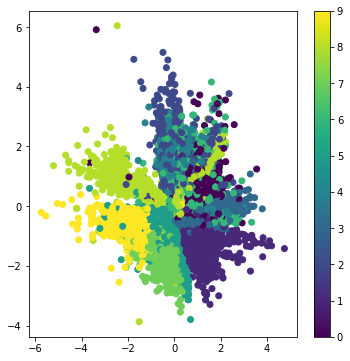

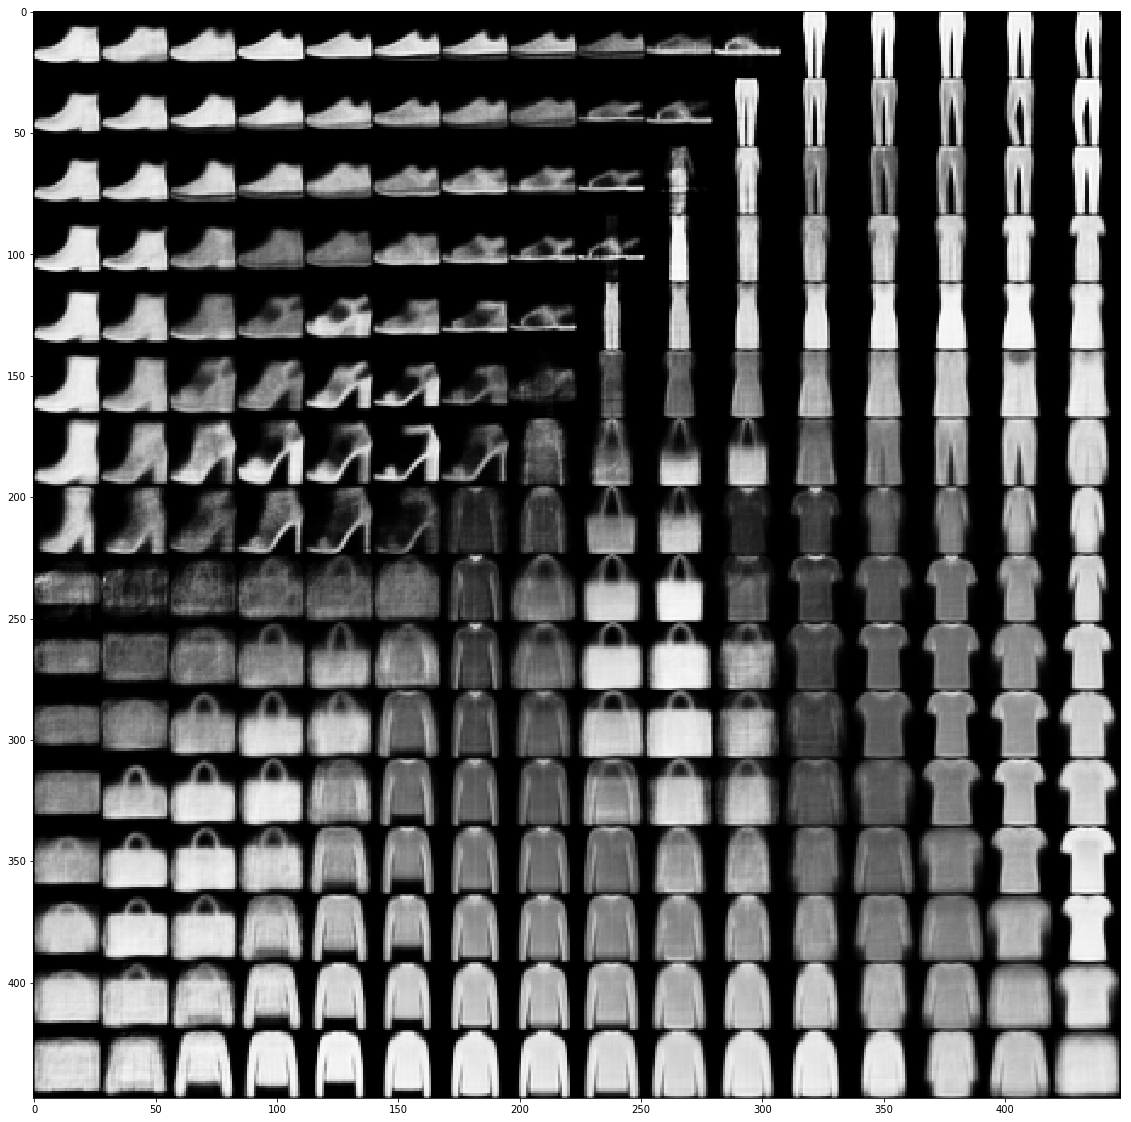

Epoch 1/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.3102
Epoch 2/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.4156
Epoch 3/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.3741
Epoch 4/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.3653
Epoch 5/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.4540
Epoch 6/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.2165
Epoch 7/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.2736
Epoch 8/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.1859
Epoch 9/300
60000/60000 [==============================] - 5s 90us/step - loss: 248.2216
Epoch 10/300
60000/60000 [==============================] - 5s 91us/step - loss: 248.1519
Epoch 11/300
60000/60000 [==============================] - 5s 91us/step - loss: 247.9669
Epoch 12/300
60000/

60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 97/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 6s 92us/st

60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 192/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 90us

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 287/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 5s 89us

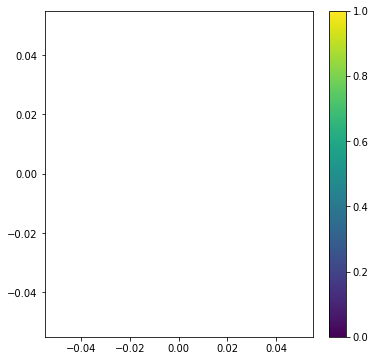

/home/marcelra/Pycharmprojects/music-generator/venv/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/marcelra/Pycharmprojects/music-generator/venv/lib/python3.6/site-packages/numpy/ma/core.py:710: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


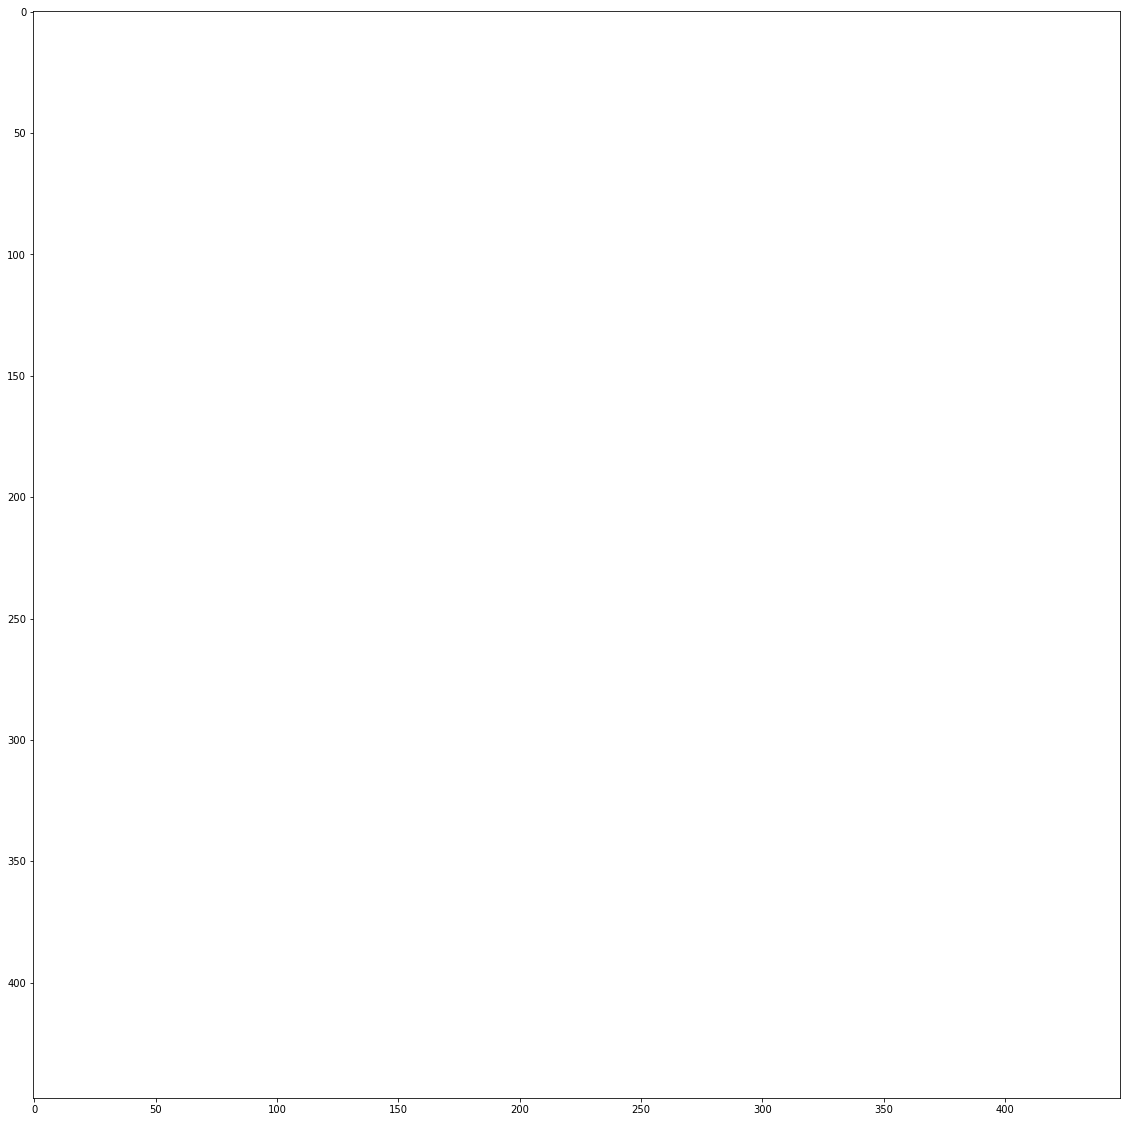

Epoch 1/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 90us/step -

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 88us/s

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 89us

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 5s 90us

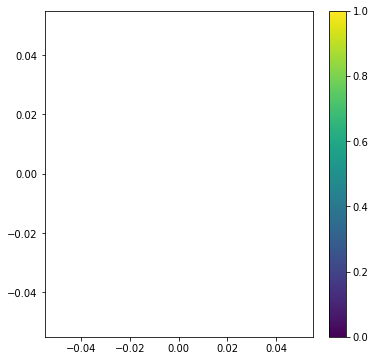

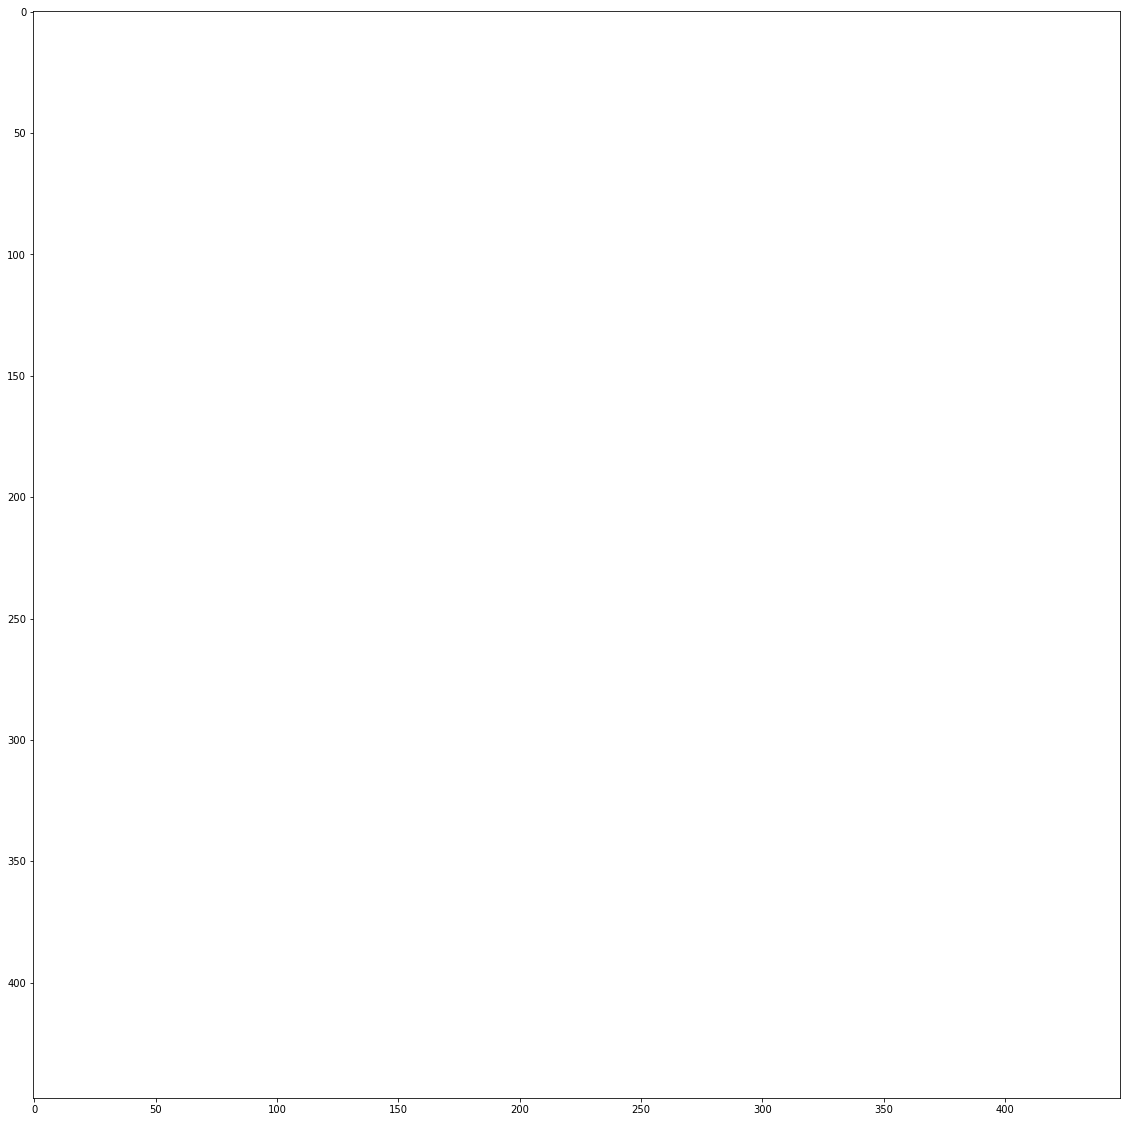

Epoch 1/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 89us/step -

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 89us/s

60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 90us

60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 92us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 5s 89us

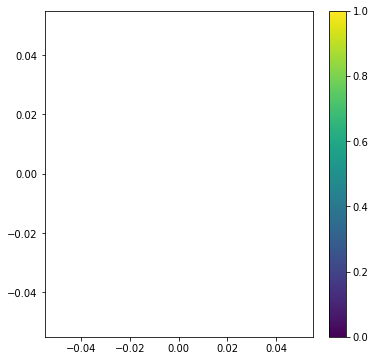

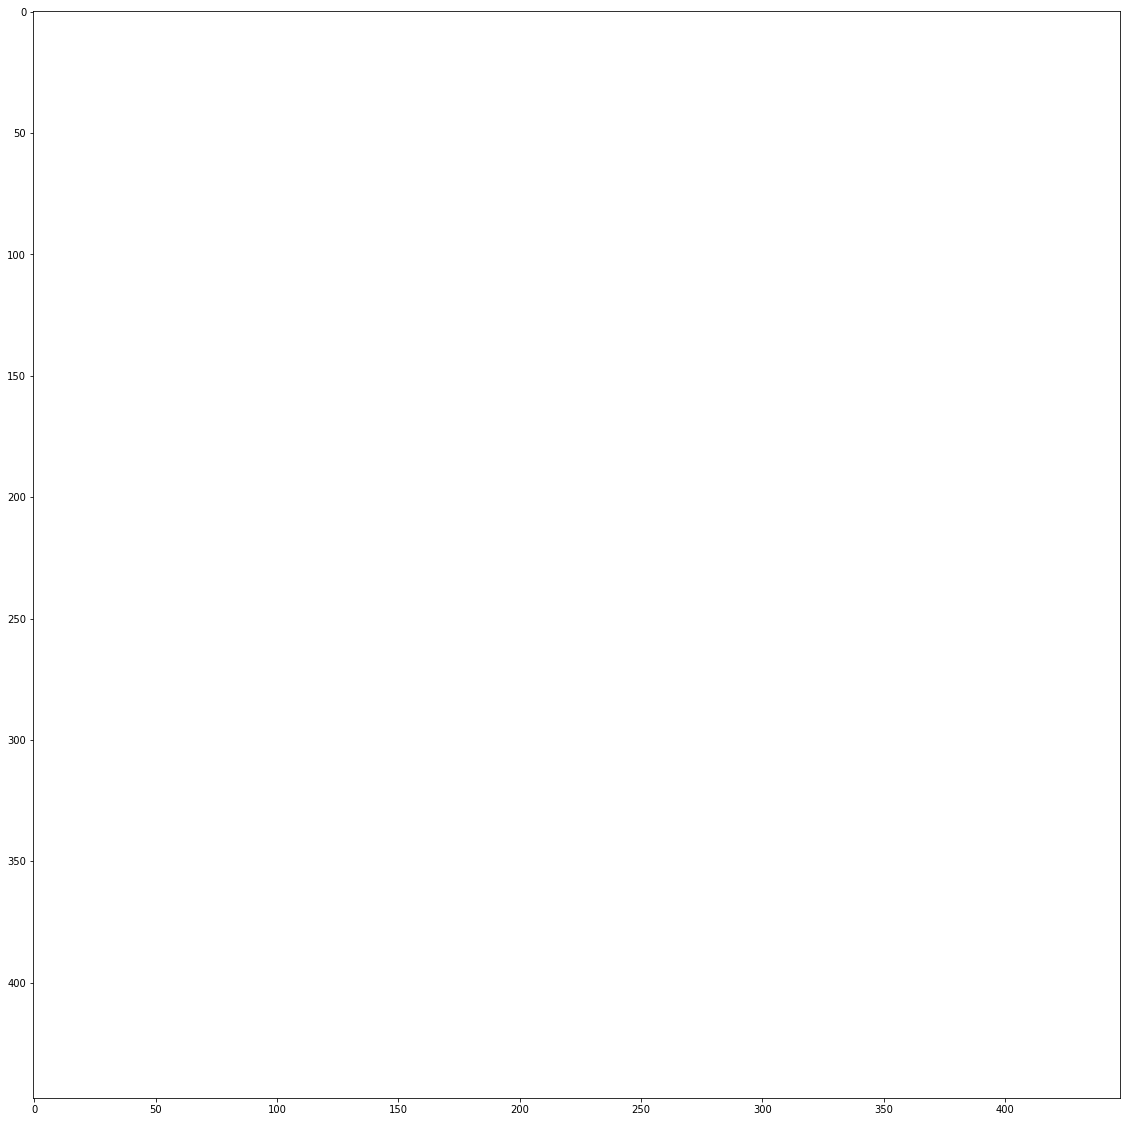

Epoch 1/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 90us/step -

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 90us/s

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 89us

60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 6s 93us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 6s 92us

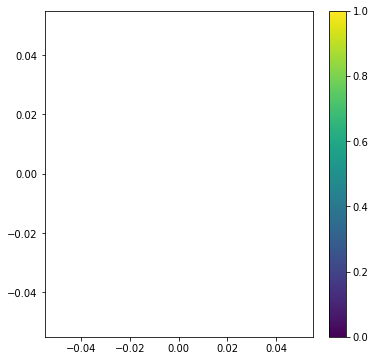

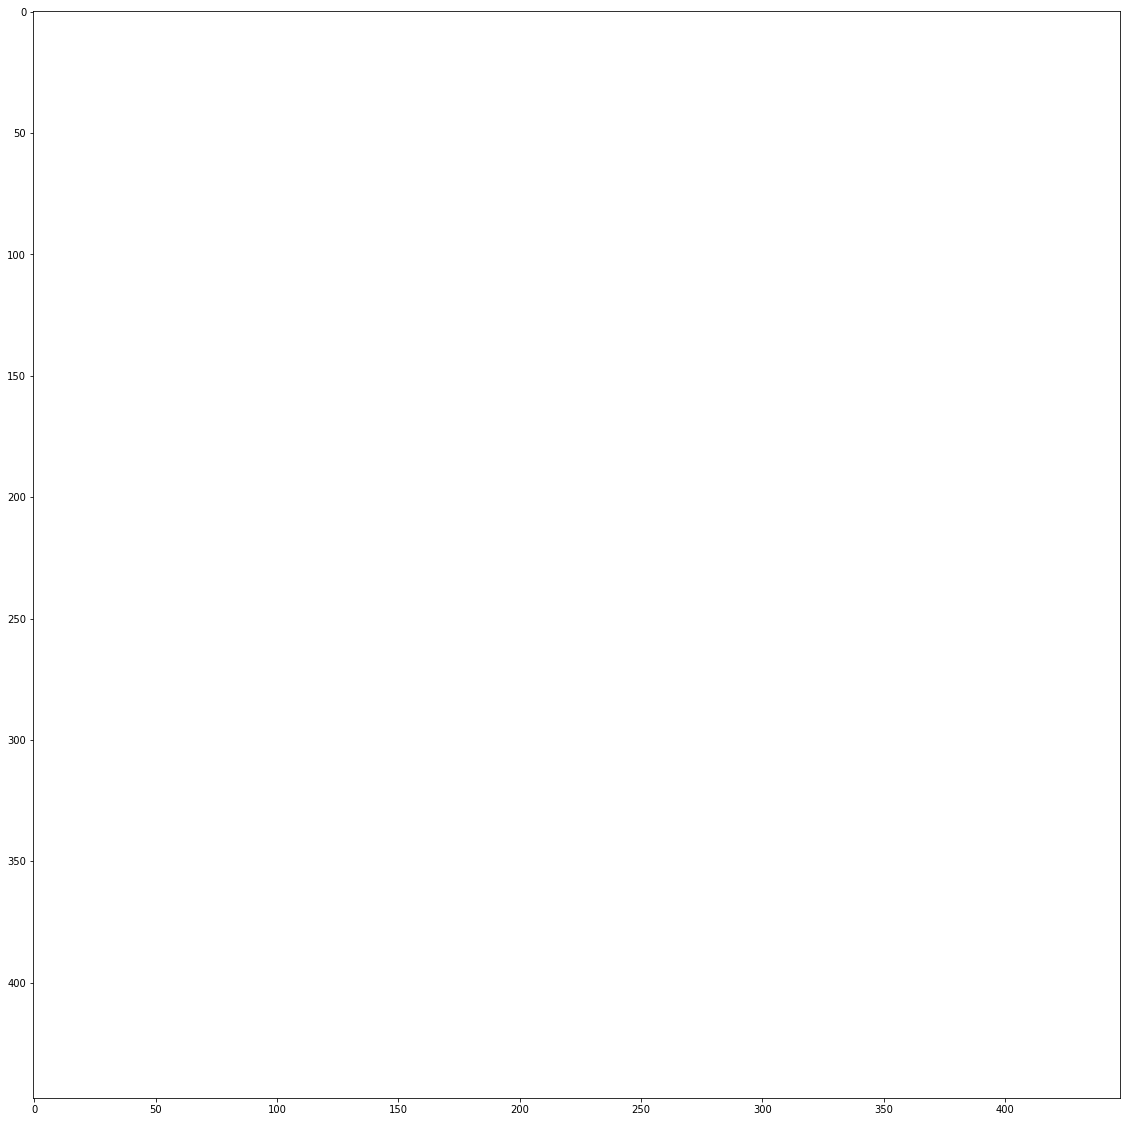

Epoch 1/300
60000/60000 [==============================] - 5s 92us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 92us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 91us/step -

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 90us/s

60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 6s 93us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 91us

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 5s 89us

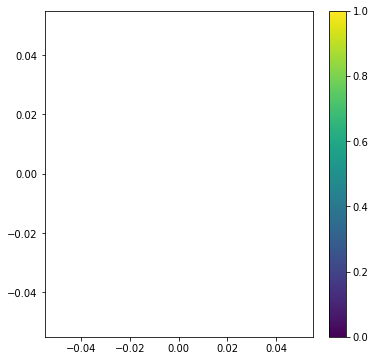

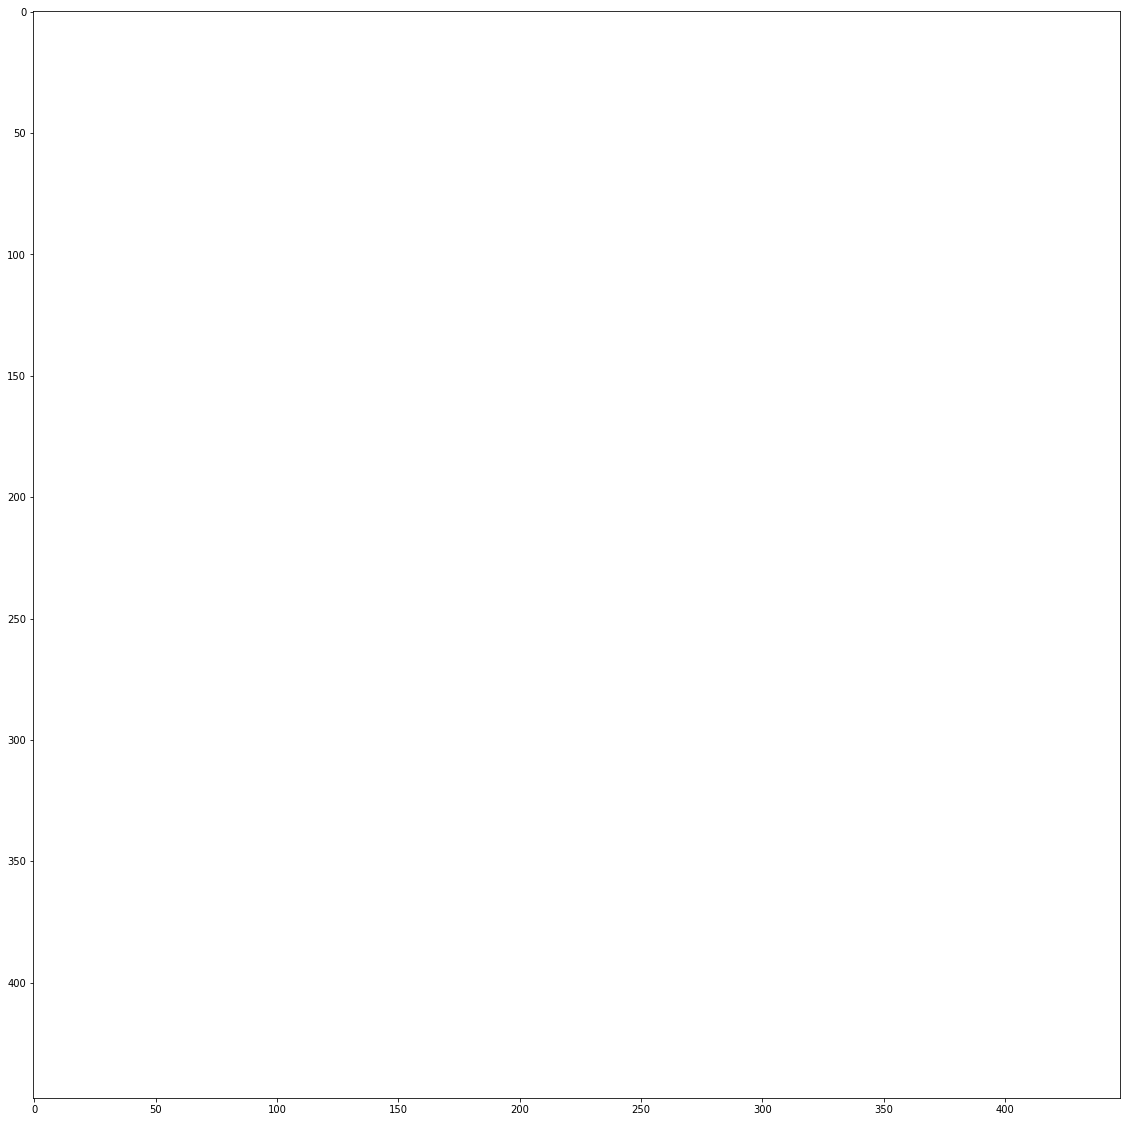

Epoch 1/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 89us/step -

60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 90us/s

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 88us

60000/60000 [==============================] - 5s 87us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 87us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 5s 88us

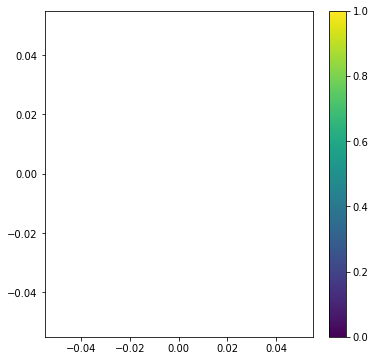

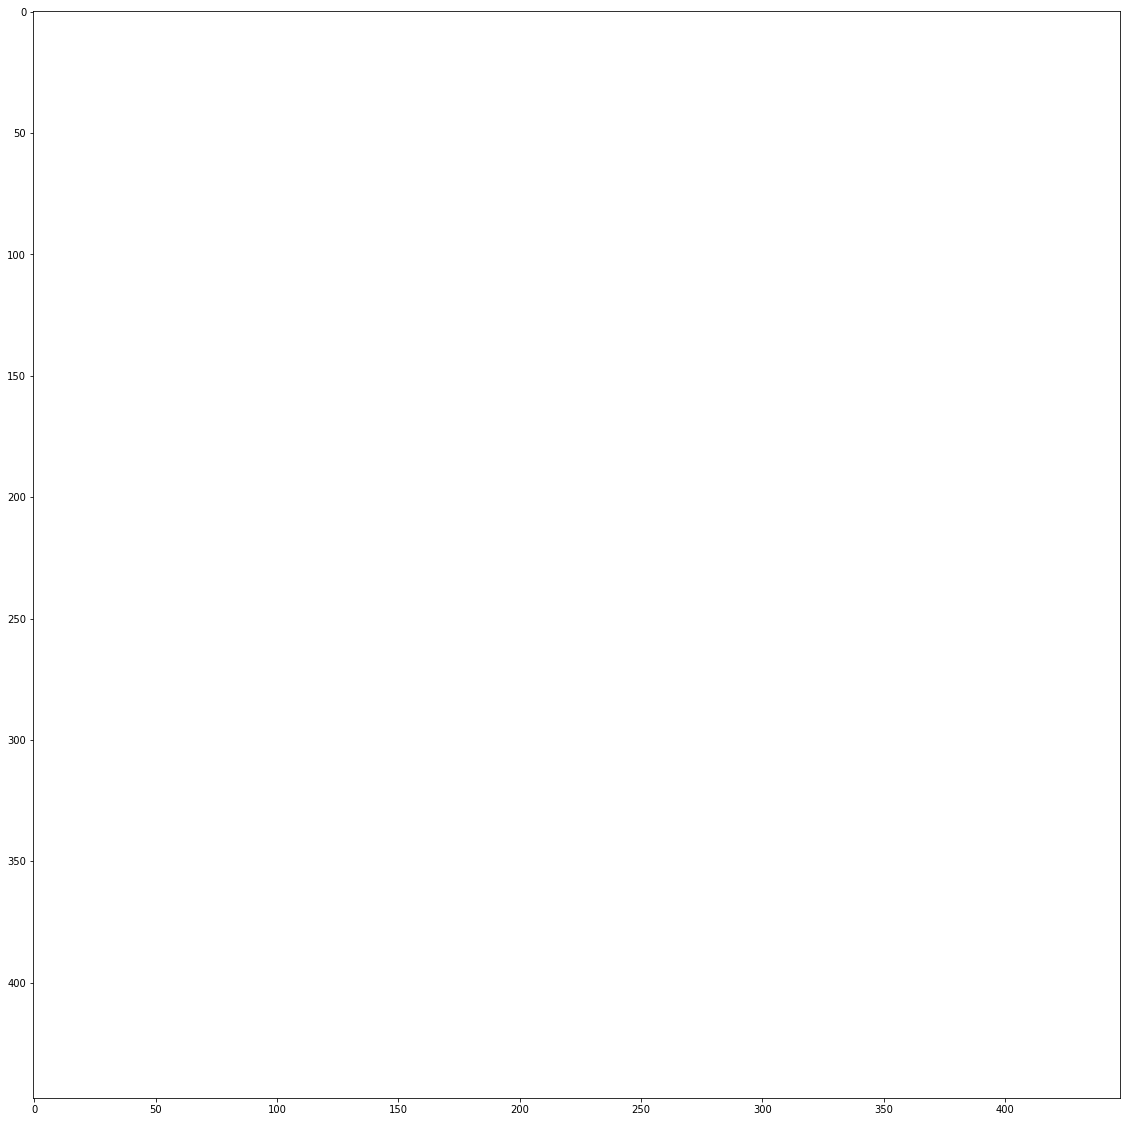

Epoch 1/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 89us/step -

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 89us/s

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 88us

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 5s 90us

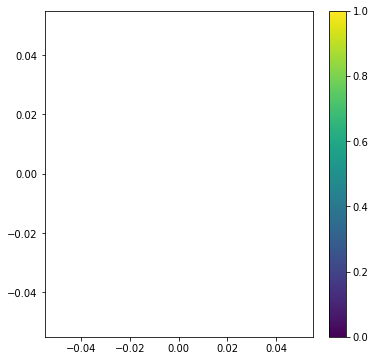

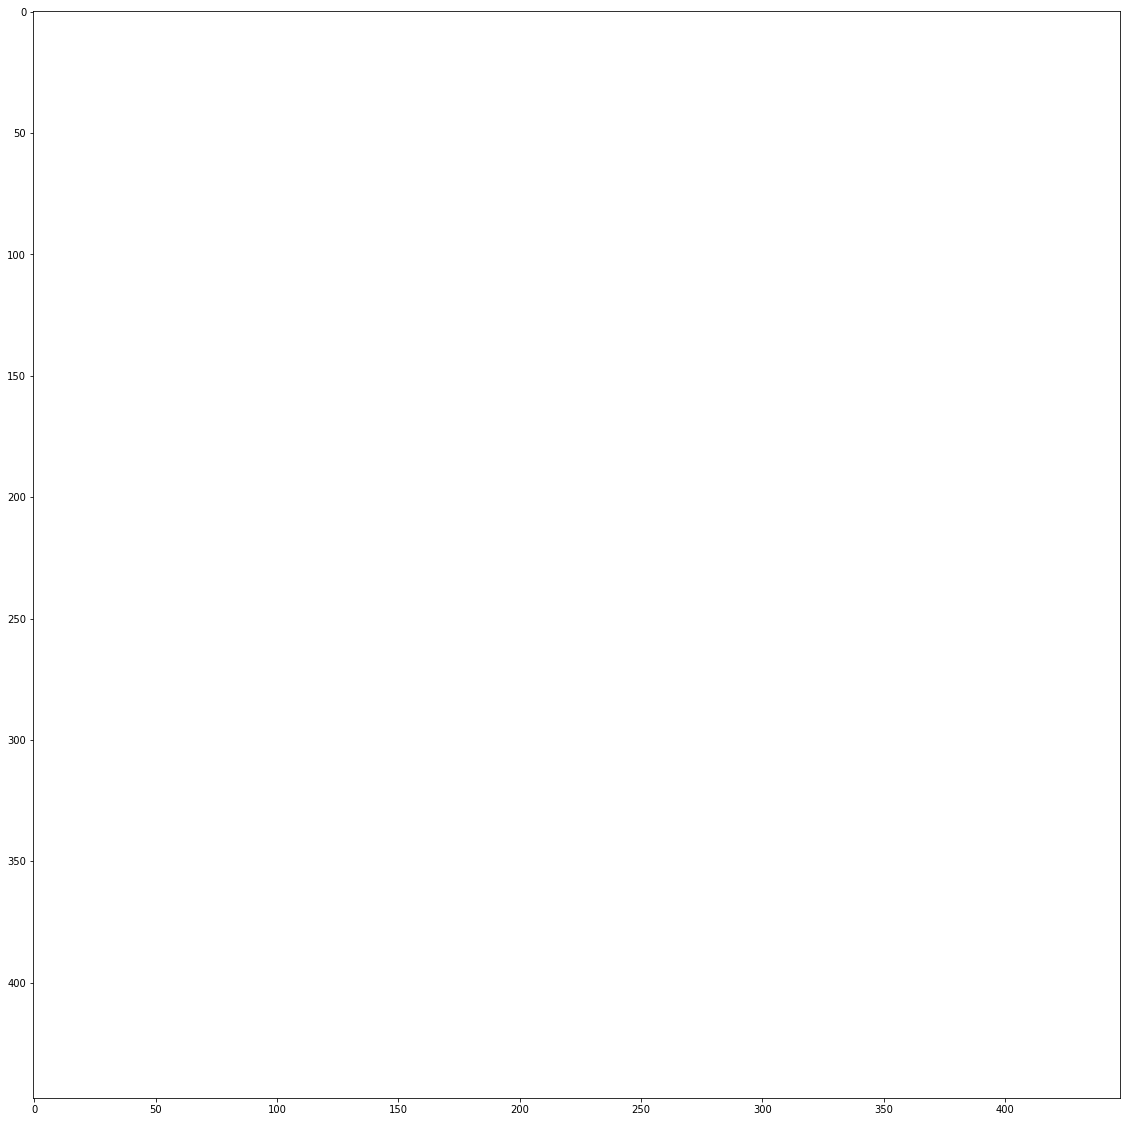

Epoch 1/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 89us/step -

60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 89us/s

60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 92us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 90us

60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 5s 91us

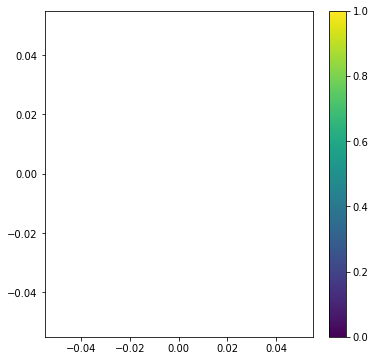

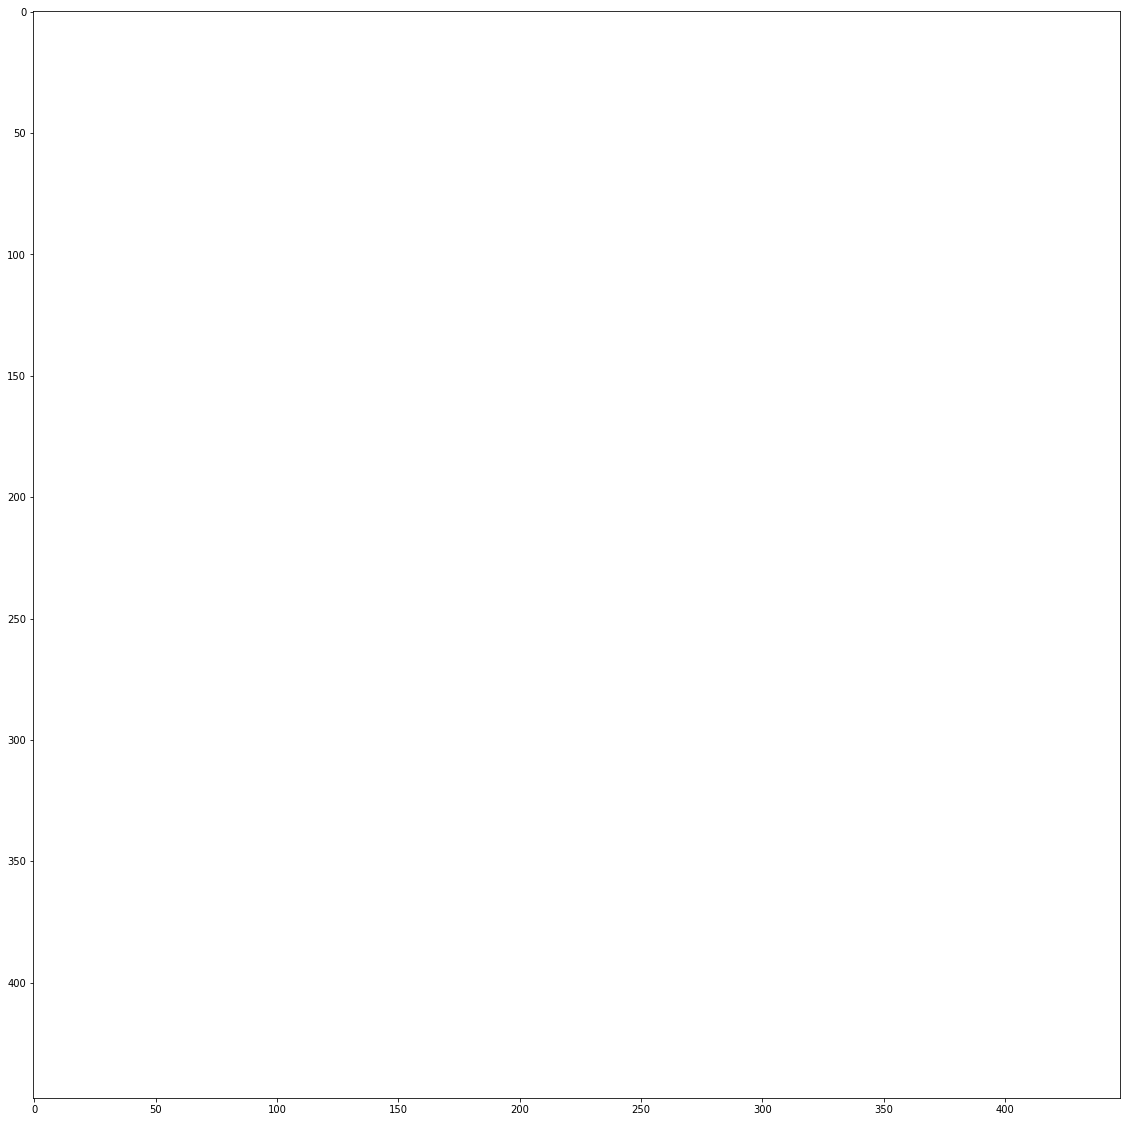

Epoch 1/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 92us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 89us/step -

60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 90us/s

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 90us

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 5s 90us

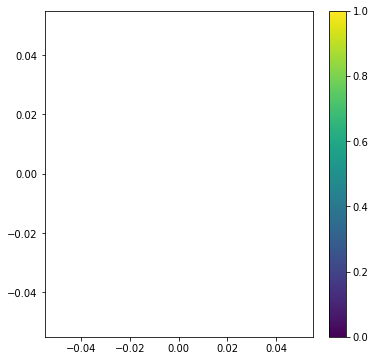

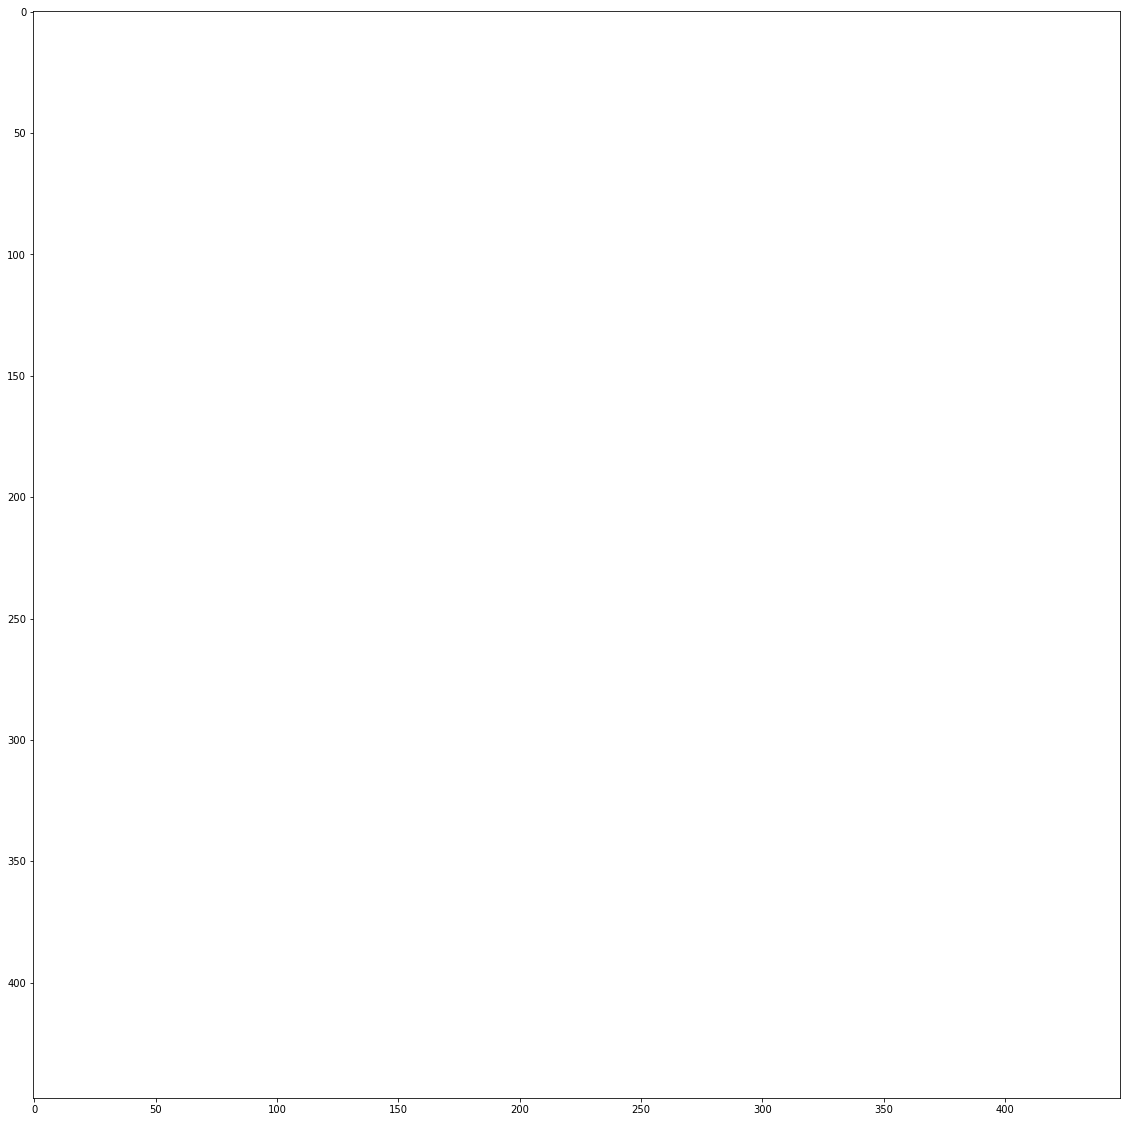

Epoch 1/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 89us/step -

60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 90us/s

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 90us

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 5s 90us

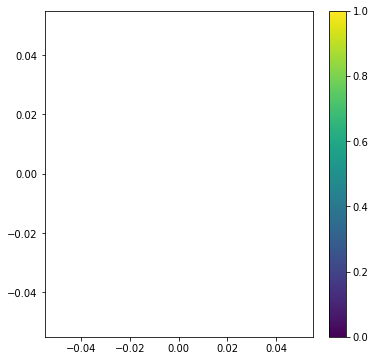

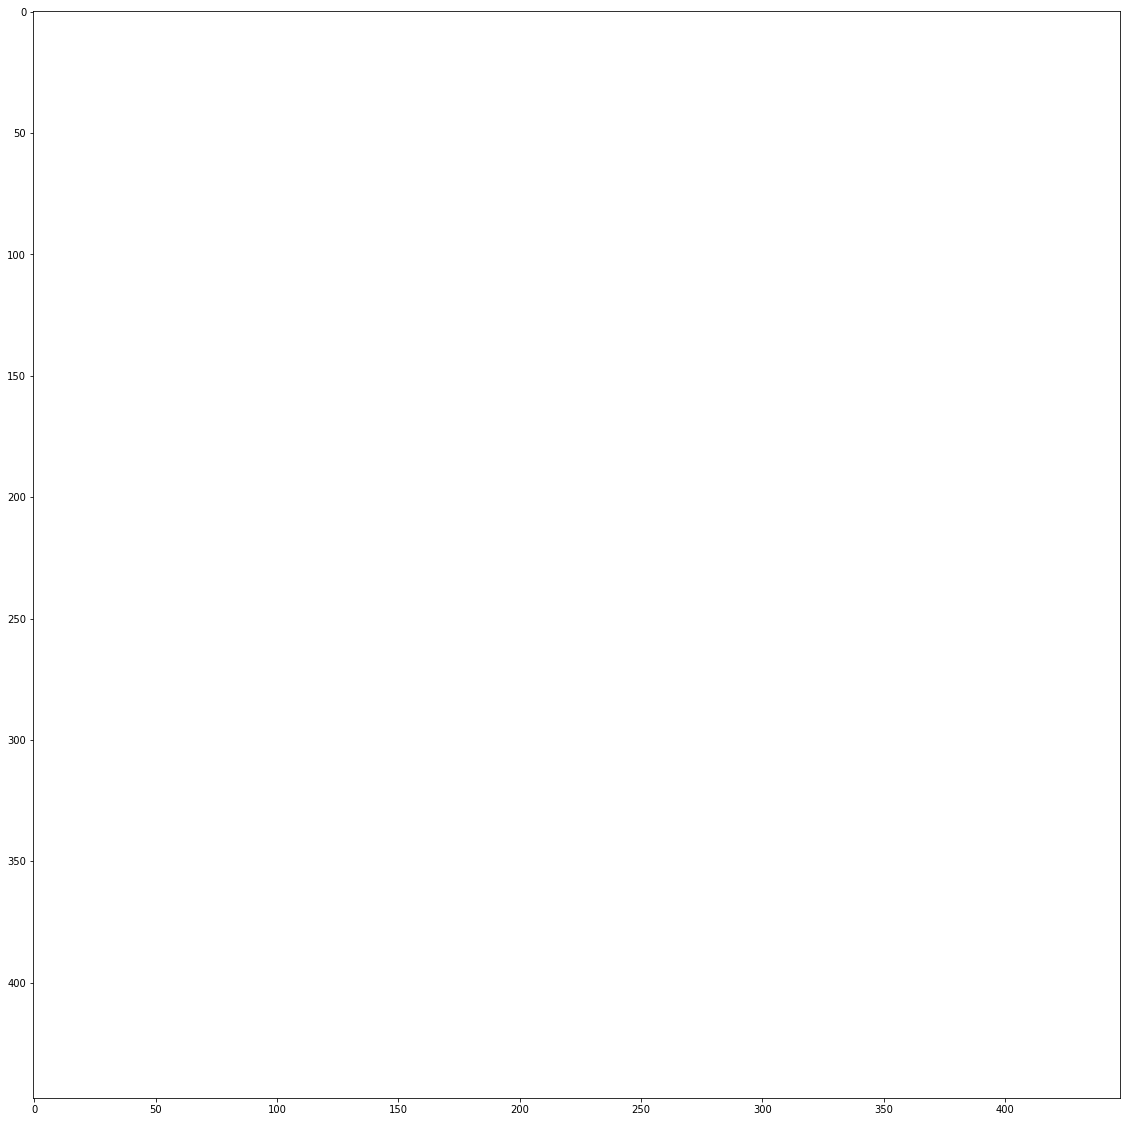

Epoch 1/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 90us/step -

60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 89us/s

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 88us

60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 5s 90us

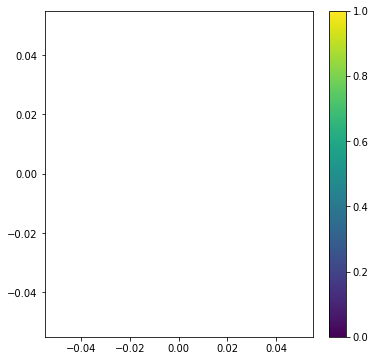

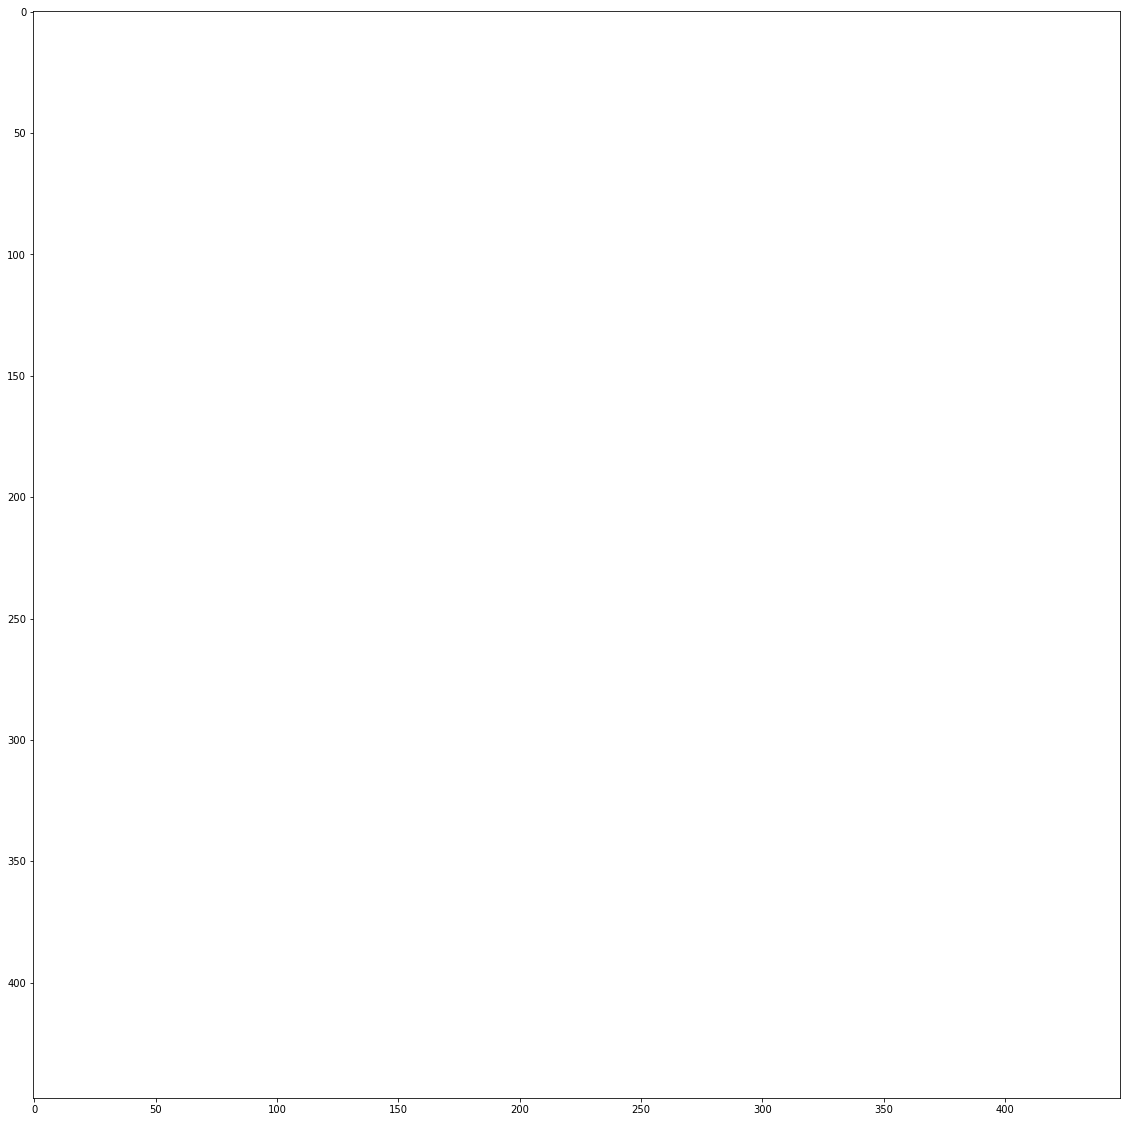

Epoch 1/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 5s 88us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 88us/step -

60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 98/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 99/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 100/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 101/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 102/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 103/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 104/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 105/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 106/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 107/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 108/300
60000/60000 [==============================] - 5s 90us/s

60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 193/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 194/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 195/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 196/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 197/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 198/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 199/300
60000/60000 [==============================] - 5s 89us/step - loss: nan
Epoch 200/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 201/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 202/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 203/300
60000/60000 [==============================] - 5s 90us

60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 288/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 289/300
60000/60000 [==============================] - 6s 93us/step - loss: nan
Epoch 290/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 291/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 292/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 293/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 294/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 295/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 296/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 297/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 298/300
60000/60000 [==============================] - 5s 91us

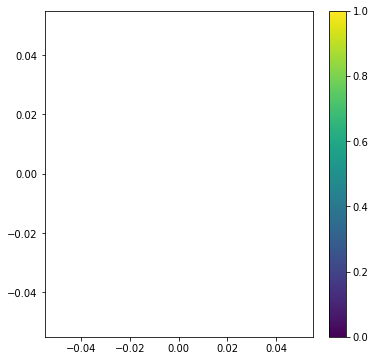

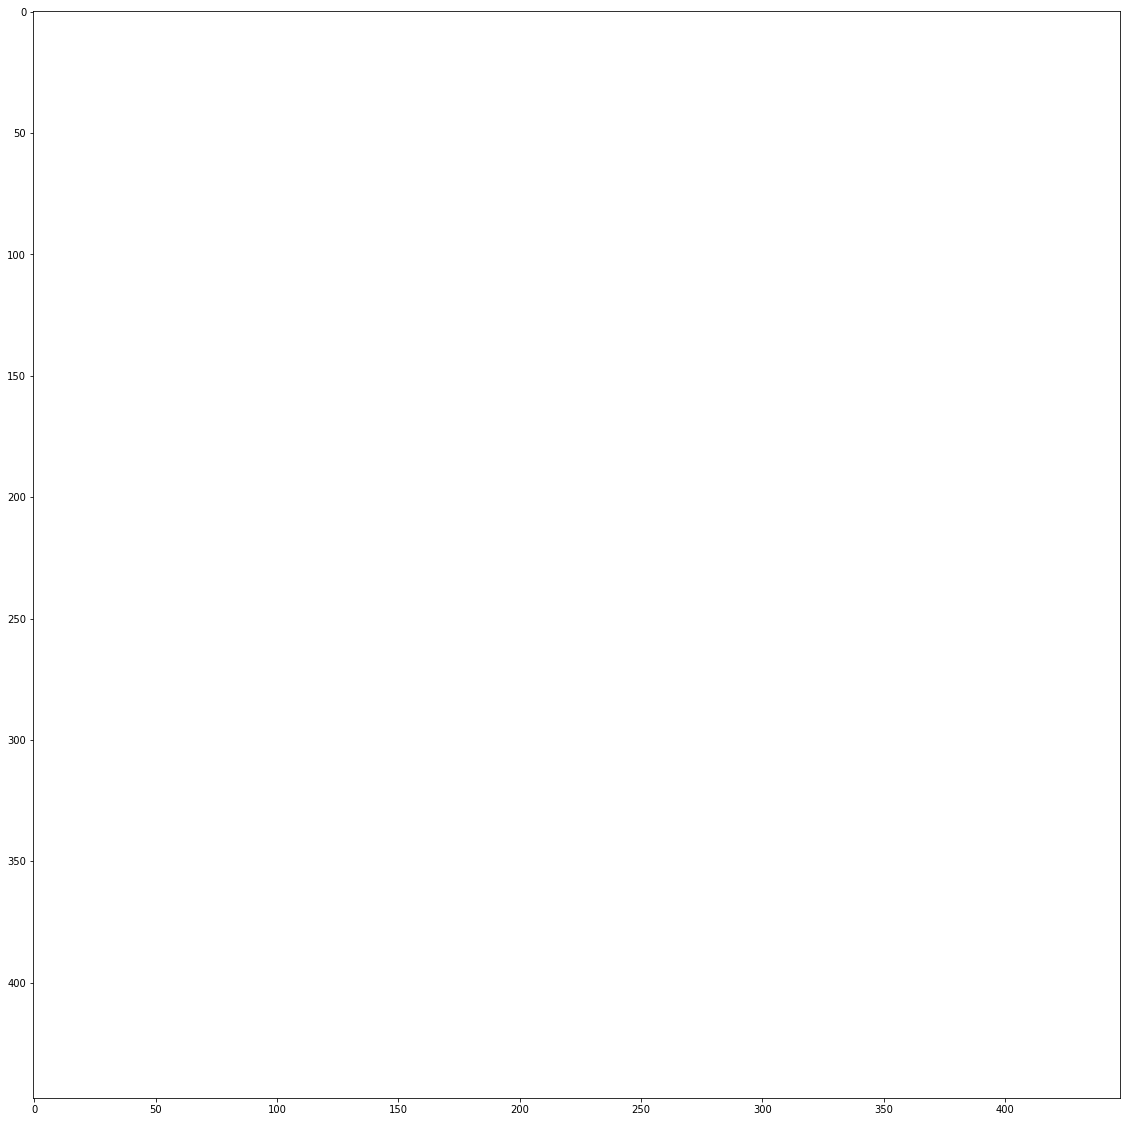

Epoch 1/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 2/300
60000/60000 [==============================] - 5s 92us/step - loss: nan
Epoch 3/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 4/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 5/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 6/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 7/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 8/300
60000/60000 [==============================] - 5s 91us/step - loss: nan
Epoch 9/300
60000/60000 [==============================] - 5s 90us/step - loss: nan
Epoch 10/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 11/300
60000/60000 [==============================] - 6s 92us/step - loss: nan
Epoch 12/300
60000/60000 [==============================] - 5s 91us/step -

In [ ]:
while True:
    fit_and_plot(n_epochs=300)